# Problem Set 3

In [539]:
import numpy as np
import scipy as sp
from scipy.sparse import csc_matrix
from scipy.sparse.linalg import spsolve
from scipy.io import loadmat
import matplotlib.tri as tri
import matplotlib.pyplot as plt
from time import process_time_ns
import random
from time import process_time_ns

We consider again the problem of designing a thermal fin of Problem Set 1 and 2. Given the reduced basis approximation implemented in PS2, we turn to implementing the associated a posteriori error estimation procedures developed in the lecture. The second half of this problem set is devoted to implementing the greedy sampling procedure. For such work We will consider the following `class` summing up and structuring implementation questions.

In [503]:
class RB_PB3:
    def __init__(self,N=8,Q=6,P=1,triangulation ='medium',test_max = 5,grid ='linlog'):
        self.N = N # RB dimension
        self.Q = Q #number of parameters
        self.case = P #case 1 or case 2
        self.triangulation = triangulation #'coarse', 'medium' or 'fine'
        self.test_max = test_max
        self.grid = grid
        
        self.N_cal = None #dimention of FE space
        self.Aq_mesh = None # FE matrix independant of parameters
        self.Fh_mesh = None # FE second term
        self.A_mu_bar = None #X inner product associated matrix
        self.mu_bar = None #mu bar of the X inner product
        self.mu_sample = None#training
        self.Bi = None #training
        self.mu = None #evaluation
        self.mu_test_lin_ln = None
        self.mu_list = [] #list of mu accepted in the test
        self.test_sample = None #grid for k
        self.test_sample_Bi = None # grid for bi
        
            
        '''stored variable offline'''
        #RB
        self.Z_ort = None
        self.Aq = None
        self.Fh = None
        #decomposizon
        self.C_C_X = None
        self.C_Lqn_X = None
        self.Lqn_lqn_X = None
        
        '''stored error bounds'''
        self.E_hat = None
        self.E_hat_direct = None         
        self.delta_en_N = None #offline/online x norm energy bound
        self.delta_en_N_direct = None #direct  x norm energy bound
        self.delta_list_direct = []
        self.delta_list_offon = []
        self.eta_en_N = None #offline/online effectivity x norm energy bound
        self.eta_en_N_direct = None #direct effectifity x norm energy bound
        self.eta_list_direct = []
        self.eta_list_offon = []
        self.e = None #u-uN excat error
        self.e_list= [] #list of exact errors throughout the test
        self.eta_min_ave_max_calc = None # offline/online effectifity array (min ave max)
        self.eta_min_ave_max_theo = None #theoritical effectivity
        self.erreur_root = None
        self.eta_s_N = None
        self.eta_s_min_ave_max_calc = []#list to store output error bound min max ave
        self.eta_s_list_offon = [] #list to store output error bound 
        self.max_s_born_effectifity_list = [] # theoritical output effectivity list
        self.relative_output_error = None
        self.relative_output_error_list = []
        self.relative_output_error_min_ave_max_calc= None #store min ave max of the relative output energy bound
        
        '''cpu time measurement'''
        self.SN_CPU= None
        self.S_CPU = None
        self.delta_s_CPU = None
        self.SN_CPU_list = []
        self.S_CPU_list = []
        self.delta_s_CPU_list = []
        
        '''Load matrices, mus, mu hat and samples'''
        self.load_matrices_samples()
        
        
    def load_matrices_samples(self):
        M = loadmat('FE_matrix.mat',simplify_cells=True)
        self.Aq_mesh=M['FE_matrix'][self.triangulation]['Ahq']
        self.Fh_mesh=M['FE_matrix'][self.triangulation]['Fh']
        
        grids = loadmat('FE_grid.mat',simplify_cells=True)
        self.N_cal = grids['FE_grid'][self.triangulation]['nodes']

        
        '''the cases are similar for \bar \mu but still repeated in case needed!'''
        k_i = np.random.uniform(0.1,10)
        if self.case ==1:
            #mu bar
            self.mu_bar=np.array([1,1,1,1,1, 0.1])
            
            #mu of the reduced basis 
            self.mu_sample = loadmat('RB_sample.mat')['RB_sample']['sample1'][0][0]
            self.Bi=np.ones(self.N)*0.1
            
            #mu evaluation        
            self.mu=np.array([k_i,k_i,k_i,k_i,1, 0.1])
            
            #mu test
            self.mu_test_lin_ln = np.array([np.linspace(0.1,10,self.test_max),\
                                  np.exp(np.linspace(np.log(0.1), np.log(10), self.test_max))])
            
            if self.grid == 'linlog':
                test_sample = self.mu_test_lin_ln.flatten() #flatten for case 1
                test_sample.sort() #sort inplace
                test_sample = list(set(test_sample))#remove duplicates
                test_sample_Bi = 0.1*np.ones(self.test_max)
            elif self.grid == 'mu_bar':
                test_sample = [self.mu_bar[0]] #question 3c
                test_sample_Bi = [0.1]
            else: #self.grid == 'mu=0.1':
                test_sample = [0.1] #question 3d
                test_sample_Bi = [0.1]
            
            '''all combinations ki and Bi'''    
            x, y = np.meshgrid(test_sample, test_sample_Bi)
            self.test_sample = x.flatten()
            self.test_sample_Bi = y.flatten()

        elif self.case ==2:
            #mu bar
            self.mu_bar=np.array([1,1,1,1,1,0.1])
            
            #training
            self.mu_sample = loadmat('RB_sample.mat')['RB_sample']['sample3'][0][0]
            self.Bi = self.mu_sample[1]
            
            #mu evaluation        
            Bi = np.random.uniform(0.01,1)
            self.mu=np.array([k_i,k_i,k_i,k_i,1, Bi])
            
            #mu test
            self.mu_test_lin_ln = np.array([np.linspace(0.1,10,self.test_max),\
                                  np.exp(np.linspace(np.log(0.1), np.log(10), self.test_max))])
            
            self.mu_test_lin_ln_Bi = np.array([np.linspace(0.01,1,self.test_max),\
                                  np.exp(np.linspace(np.log(0.01), np.log(1), self.test_max))])
            
            if self.grid == 'linlog':
                #ki
                test_sample = self.mu_test_lin_ln.flatten() #flatten for case 1
                test_sample.sort() #sort inplace
                test_sample = list(set(test_sample))#remove duplicates
                test_sample_Bi = 0.1*np.ones(self.test_max)
                
                #Bi
                test_sample_Bi = self.mu_test_lin_ln_Bi.flatten() #flatten for case 1
                test_sample_Bi.sort() #sort inplace
                test_sample_Bi = list(set(test_sample_Bi))#remove duplicates
                
                '''all combinations ki and Bi'''    
                x, y = np.meshgrid(test_sample, test_sample_Bi)
                self.test_sample = x.flatten()
                self.test_sample_Bi = y.flatten()
            else:
                pass
            
        else:
            print("No such case available!! Only case 1 or 2 are taken into account!")

        self.A_mu_bar = self.assembleA(self.mu_bar,self.Aq_mesh)
        
    def generate_new_mu(self):
        
        k_i = np.random.uniform(0.1,10)
        if self.case ==1:
            #mu evaluation        
            self.mu=np.array([k_i,k_i,k_i,k_i,1, 0.1])

        elif self.case ==2:
            #mu evaluation        
            Bi = np.random.uniform(0.01,1)
            self.mu=np.array([k_i,k_i,k_i,k_i,1, Bi])
            
        else:
            print("No such case vailable!! Only cases 1 or 2 are taken into account!")
    
    def inner_prod_A(self,u,v):
        return u.T@self.A_mu_bar@v
    
    def assembleA(self,mu,Aq):
        A=csc_matrix(np.shape(Aq[0]))
        for k in range(0,6):
            A+=mu[k]*Aq[k]
        return A
    
    def Gram_Schmidt_inplace(self,A,u,i):
        v = u.copy()
        for k in range(i):
            v[:,i]-=self.inner_prod_A(u[:,i],u[:,k])*u[:,k]
        v[:,i] = v[:,i]/np.sqrt(self.inner_prod_A(v[:,i],v[:,i]))
        return v[:,i]
    
    def offline_calculation_RB(self):
        #calculation of orthonormalized Z
        self.Z_ort = np.zeros((self.N_cal,self.N))
        self.Aq = np.ndarray((self.Q,self.N,self.N))
        self.Fh = np.zeros(self.N)
        
        for i in range(self.N):
            mu=np.array([self.mu_sample[0][i],self.mu_sample[0][i], self.mu_sample[0][i],\
                         self.mu_sample[0][i],1, self.Bi[i]])

            A=self.assembleA(mu,self.Aq_mesh)
            u = spsolve(A, self.Fh_mesh)
            self.Z_ort[:,i] = u[:]
            self.Z_ort[:,i] = self.Gram_Schmidt_inplace(A,self.Z_ort,i)

        for i in range(self.Q):
            self.Aq[i,:,:] = self.Z_ort.T @ self.Aq_mesh[i] @ self.Z_ort

        self.Fh = self.Z_ort.T @ self.Fh_mesh
        
    
    def offline_decomposition(self):
        '''Z, Aq,Fh'''
        self.offline_calculation_RB()

        '''solve C and forming (C,C)_X'''
        C = spsolve(self.A_mu_bar,self.Fh_mesh)
        C_C_X = self.inner_prod_A(C,C)

        '''solve Lnq'''
        Lqn = np.zeros((self.Q,self.N,self.N_cal))
        C_Lqn_X = np.zeros((self.Q,self.N))
        for q in range(self.Q):
            for n in range(self.N):
                Lqn[q,n,:] = spsolve(self.A_mu_bar, -self.Aq_mesh[q] @ self.Z_ort[:, n])[:]

        '''forming (C,Lqn)_X '''
        for q in range(self.Q):
            for n in range(self.N):
                C_Lqn_X[q,n] = self.inner_prod_A(Lqn[q,n,:],C[:])

        '''forming (lq'n',lqn)_X'''
        Lqn_lqn_X = np.zeros((self.Q,self.N,self.Q,self.N))
        for q in range(self.Q):
            for n in range(self.N):
                for p in range(self.Q):
                    for m in range(self.N):
                        Lqn_lqn_X[q,n,p,m] = self.inner_prod_A(Lqn[q,n,:],Lqn[p,m,:])

        '''saving'''
        self.C_C_X = C_C_X
        self.C_Lqn_X = C_Lqn_X
        self.Lqn_lqn_X = Lqn_lqn_X
        
        return self
        
    def online_decomposition(self):

        '''calculate UN'''
        A_N = self.assembleA(self.mu,self.Aq)
        UN = np.linalg.solve(A_N,self.Fh)
        
        delta_start = process_time_ns() #time start
        ''''calculating ||Ê||²'''
        self.E_hat = self.C_C_X
        for q in range(self.Q):
            for n in range(self.N):
                output = 2*self.C_Lqn_X[q,n]
                for p in range(self.Q):
                    for m in range(self.N):
                        output += self.mu[p]*UN[m]*self.Lqn_lqn_X[q,n,p,m]
                self.E_hat += self.mu[q]*UN[n]*output
                
        '''calculate x norme energy bound'''
        self.delta_en_N = np.sqrt(np.abs(self.E_hat/min(self.mu/self.mu_bar)))
        delta_stop = process_time_ns() 
        delta_time = delta_stop - delta_start#time stop SN
        self.delta_s_CPU_list.append(delta_time)
    
        return self.delta_en_N

    def compute_energy_error_direct(self):
        #self.offline_calculation_RB() #commented as it is already done in the offline_decomposition

        A = self.assembleA(self.mu,self.Aq_mesh)
        A_N = self.assembleA(self.mu,self.Aq)
        #calcul de UN
        UN = np.linalg.solve(A_N,self.Fh)

        E = spsolve(self.A_mu_bar, self.Fh_mesh - A @ self.Z_ort @ UN)
        
        self.E_hat_direct = E.T @ self.A_mu_bar @ E

        '''calculate x norme energy bound'''
        self.delta_en_N_direct  = np.sqrt(np.abs(self.E_hat/min(self.mu/self.mu_bar)))
        
        '''calculate the exact error'''
        #uN
        U_N = self.Z_ort@UN

        #u
        A = self.assembleA(self.mu,self.Aq_mesh)
        U = spsolve(A,self.Fh_mesh)
        self.e = np.sqrt(self.inner_prod_A(U-U_N,U-U_N))#||u-uN||x

        return self.delta_en_N_direct
    
    def energy_bound_comparison(self,P=1,Nmax=9):
        for N in range(1,Nmax):
            
            self.N = N
            self.Q = 6
            self.case = P #default case 1
            
            '''generate mu'''
            self.generate_new_mu()
            
            '''offline/online method'''
            offline_step = self.offline_decomposition() #Z_ort, Aq and Fh are constructed here as well
            delta_en_N = offline_step.online_decomposition()
            self.delta_list_offon.append(delta_en_N)
            '''direct'''
            delta_en_N_direct = self.compute_energy_error_direct()
            self.delta_list_direct.append(delta_en_N_direct)
            
        print("Comparison done successfully!! outputs are respectively: offline/online, direct!")
        return self.delta_list_offon, self.delta_list_direct
        
    def plot_delta_comparison(self):
        N = len(self.delta_list_offon)+1
        fig, ax = plt.subplots(figsize=(9,6))
        ax.set(xlabel='RB dimension(N)', ylabel=r'The X norm energy bound ($\Delta_N^{en}$)', \
               title= r"Comparison of two ways of energy bound calculation for random parameters $\mu$")
        ax.plot(range(1,N),self.delta_list_offon,label=r"offline/online method ")
        ax.plot(range(1,N),self.delta_list_direct,'o',label=r"Direct method")
        ax.set_yscale('log')
        ax.grid(True)
        ax.legend(loc='best',fontsize=15);
        
    def effectivity_min_max_ave(self,tol=10e-11,output=False):
        '''offline'''
        self.offline_decomposition()
        self.list_mu = []
        max_born_effectifity_list = []
        
        for mu in zip(self.test_sample,self.test_sample_Bi):

            self.mu = [mu[0],mu[0],mu[0],mu[0],1,mu[1]]
            '''calculate u-uN '''
            #uN
            SN_start = process_time_ns() #time start
            
            A_N = self.assembleA(self.mu,self.Aq)
            U_N = np.linalg.solve(A_N,self.Fh) 
            
            SN_stop= process_time_ns() 
            SN_time = SN_stop - SN_start#time stop
            
            UN = self.Z_ort@U_N

            #u
            S_start = process_time_ns() #time start
            
            A = self.assembleA(self.mu,self.Aq_mesh)
            U = spsolve(A,self.Fh_mesh)
            
            S_stop= process_time_ns() 
            S_time = S_stop - S_start#time stop
            
            '''error equation e'''
            self.e = np.sqrt(self.inner_prod_A(U-UN,U-UN))#||u-uN||x 
            e_u =U-UN
            e_A = np.sqrt(e_u.T@A@e_u) #|||e|||_{\mu}
            
            '''calculation of output s-sN''' 
            SN_start = process_time_ns() #time start
            
            T_root_N = self.Fh.T@U_N
            
            SN_stop = process_time_ns() 
            SN_time =SN_time + SN_stop - SN_start#time stop SN
            self.SN_CPU_list.append(SN_time)
            
            S_start = process_time_ns() #time start
            
            T_root = self.Fh_mesh.T@U
            
            S_stop= process_time_ns() 
            S_time += S_stop - S_start#time stop
            self.S_CPU_list.append(S_time)
            
            self.erreur_root = np.abs(T_root - T_root_N)
            
            if output:
                erreur = self.erreur_root
            else:
                erreur = self.e
                
            '''online'''
            '''calculate x norm energy bound'''
            if (erreur >tol):
                self.list_mu.append(self.mu)#append mu
                self.e_list.append(self.e) #append 
                
                #time start inside this method
                delta_en_offon = self.online_decomposition()
                
                self.delta_list_offon.append(delta_en_offon)
                ''' calculate effectivity'''
                self.eta_en_N = delta_en_offon/e_A #energy error bount
                self.eta_list_offon.append(self.eta_en_N)
                
                '''theoritical effectivity'''
                max_born_effectifity_list.append(np.sqrt(max(self.mu/self.mu_bar)/min(self.mu/self.mu_bar)))#gamma/alpha
                
                '''output theoritical effectivity'''
                self.max_s_born_effectifity_list.append(np.sqrt(max(self.mu/self.mu_bar)/min(self.mu/self.mu_bar)))#gamma/alpha
        
                '''calculation of output error bound'''
                delta_s_en = delta_en_offon*delta_en_offon #output energy bound
                self.eta_s_N = delta_s_en /self.erreur_root
                self.eta_s_list_offon.append(self.eta_s_N)
                
                '''calculation of the relative output error bound'''
                self.relative_output_error = delta_s_en/T_root_N
                self.relative_output_error_list.append(self.relative_output_error)
         
        
        self.eta_min_ave_max_calc = [min(self.eta_list_offon),np.mean(self.eta_list_offon),\
                                max(self.eta_list_offon)]
        
        self.eta_s_min_ave_max_calc = [min(self.eta_s_list_offon),np.mean(self.eta_s_list_offon),\
                                max(self.eta_s_list_offon)]
        
        self.relative_output_error_min_ave_max_calc = [min(self.relative_output_error_list),np.mean(self.relative_output_error_list),\
                                max(self.relative_output_error_list)]
        
        '''effectivity theoriy according to (23) lecture 3'''
        min_born_effectivity = np.sqrt(min(max_born_effectifity_list))
        max_born_effectifity = np.sqrt(max(max_born_effectifity_list))
        ave_effectifvity = np.sqrt(np.mean(max_born_effectifity_list))
        
        self.eta_min_ave_max_theo = [min_born_effectivity,ave_effectifvity,max_born_effectifity]
        
        
        '''output effectivity theoriy according to (24) dlecture 3'''
        min_born_effectivity_s = min(self.max_s_born_effectifity_list)
        max_born_effectifity_s = max(self.max_s_born_effectifity_list)
        ave_effectifvity_s = np.mean(self.max_s_born_effectifity_list)
        
        self.eta_s_min_ave_max_theo = [min_born_effectivity_s,ave_effectifvity_s,max_born_effectifity_s]

        #print("The theoritical effectivity: \n \t \t [eta_min, eta_ave,eta_max] = ",self.eta_min_ave_max_theo)
        #print("The calculated effectivity: \n \t \t [eta_min, eta_ave,eta_max] = ",self.eta_min_ave_max_calc )
        
        '''SN cpu'''
        self.SN_CPU = np.mean(self.SN_CPU_list)
        '''S cpu'''
        self.S_CPU = np.mean(self.S_CPU_list)
        '''delta_s cpu'''
        self.delta_s_CPU = np.mean(self.delta_s_CPU_list)

        return self.eta_min_ave_max_theo,self.eta_min_ave_max_calc
        
        

In [504]:
def test():
    test = RB_PB3(N=8,Q=6,P=2,triangulation ='medium',test_max = 5,grid ='linlog')
    test.effectivity_min_max_ave(tol=10e-9)
    print("output energy bound",test.eta_s_min_ave_max_calc)
    print("output energy bound expected ",test.eta_s_min_ave_max_theo)
    print("relative output energy bound",test.relative_output_error_min_ave_max_calc)
    print("cpu time for SN, S, and delta_s is :\n", test.SN_CPU,test.S_CPU,test.delta_s_CPU,"ns")
test()

output energy bound [0.9999999999993272, 5.906560226169085, 38.28493101969902]
output energy bound expected  [1.0000000000000002, 3.6635617003761, 8.674675786448738]
relative output energy bound [4.985487100686082e-07, 0.01133512565184639, 0.04552343989066066]
cpu time for SN, S, and delta_s is :
 678638.4 37940724.53333333 7650206.858974359 ns


# Part 1:  Coercivity Lower Bound and X-Norm Error Bound

We first consider the construction of the lower bound for the coercivity constant.

## Question 1:

Since our problem is parametrically coercive, the simple min $\Theta-approach$ suffices for the construction of the coercivity lower bound, $\alpha_{LB}(\mu)$. However, we have to slightly adapt the lower bound to Case I and II.

### Sub-question (a):

Derive an explicit expression for $\alpha_{LB}(\mu)$ for Case I and Case II.

from the following decomposition:
    $$a(u,v,\mu) =\sum_{q=1}^Q \Theta^q(\mu)a(u,v)^q . \quad \quad $$
    
Combined with:
    $$\alpha(\mu)= inf_v \frac{a(v,v,\mu)}{{\left\Vert v\right\Vert}^2_X}$$
    
We obtain:
 $$\alpha(\mu)= inf_v \sum_{q=1}^Q \Theta^q(\mu) \frac{a(v,v)^q}{{\left\Vert v\right\Vert}^2_X} \quad \quad  (*)$$
    
For a chosen $\bar \mu$ we have as well:

$$\alpha(\bar \mu)= inf_v \sum_{q=1}^Q \Theta^q(\bar \mu) \frac{a(v,v)^q}{{\left\Vert v\right\Vert}^2_X} \quad \quad (**) $$

We multiply and divide $(*)$ by $\Theta^q(\bar \mu)$ and we sustitute $(**)$ in $(*)$ and we obtain:

$$\alpha(\mu) \geq min_q \frac{\Theta^q(\mu) }{\Theta^q(\bar \mu) } \alpha(\bar \mu)$$

which leads to the expression of the coercivity lower bound:
$$\fbox {$\alpha_{LB}(\mu) = min_q \frac{\Theta^q(\mu) }{\Theta^q(\bar \mu) } \alpha(\bar \mu) $}  \quad \quad with \, \,\alpha(\bar \mu)=1 $$

We distinguish two cases:

**$\alpha_{LB}(\mu)$ for Case I:**

In that case $\mu = (k,k,k,k,1,0.1)$ with $k \in [0.1,10]$. And $\bar \mu = (1,1,1,1,1,0.1)$. 

So $min_q \frac {\Theta^q(\mu)}{\Theta^q(\bar \mu)} = \frac {1}{1}$.

Given that $\alpha(\bar \mu)=1$, in that case: $$\alpha_{LB}(\mu) = 1$$

**$\alpha_{LB}(\mu)$ for Case II:**

In that case $\mu = (k,k,k,k,1,Bi)$ with $(k,Bi) \in [0.1,10]\times [0.01,1]$. And $\bar \mu = (1,1,1,1,1,0.1)$. 

So $min_q \frac {\Theta^q(\mu)}{\Theta^q(\bar \mu)} = \frac {0.1}{1} = \frac {0.01}{0.1}$.

Given that $\alpha(\bar \mu)=1$, in that case: $$\alpha_{LB}(\mu) = 0.1$$

### Sub-question (b):

What is the largest effectivity for the energy norm error bound and the output error bound we should anticipate for Case I and Case II?

According to the lecture, the effectivity for the energy error bound is expressed as follows: $$1 \leq \eta_N^{en}(\mu) \leq \sqrt {\frac{\gamma_{UB}}{\alpha_{LB}}} $$

So the largest effectiivity can be estimated as:
$$\eta_{N,{max}}^{en}(\mu) =  \sqrt {\frac{\gamma_{UB}}{\alpha_{LB}}} $$

We already estimated $\alpha_{LB} = min_q \frac {\Theta^q(\mu)}{\Theta^q(\bar \mu)}  $

With the same approach we can estimate $\gamma_{UB} = max_q \frac {\Theta^q(\mu)}{\Theta^q(\bar \mu)} $

**In case I:**

$$\eta_{N,{max}}^{en}(\mu) =  \sqrt {\frac{\gamma_{UB}}{\alpha_{LB}}} = \sqrt {\frac{10}{1}} = 3.16$$

**In case II:**

$$\eta_{N,{max}}^{en}(\mu) =  \sqrt {\frac{\gamma_{UB}}{\alpha_{LB}}} = \sqrt {\frac{10}{0.1}} = 10$$

## Question 2:

Prove the bounding properties of the X-norm error bound, i.e., the effectivity
$\eta_N(\mu)$ satisfies :
    
$$1 \leq \eta_N(\mu) \leq {\frac{\gamma_{UB}}{\alpha_{LB}}} $$

In one hand:

We have that relative output effectivity is:
$$\Delta_{N}(\mu) = \frac {{\left\Vert  \hat e(\mu)\right\Vert}_X} {{\alpha_{LB}(\mu)}}$$

Which we replace in the relative output bound:

$$\eta_{N}(\mu) = \frac {{\left\Vert  e(\mu)\right\Vert}_X}  {\alpha_{LB}(\mu)}$$

And we obtain:

$$\eta_{N}(\mu) = \frac {{\left\Vert \hat e(\mu)\right\Vert}_X}  {\alpha_{LB}(\mu) \left\Vert e(\mu)\right\Vert}_X$$

Given that:

${\left\Vert e(\mu)\right\Vert}_X = u(\mu) - u_N(\mu)$ and $a(e(\mu),v,\mu) = r(u_N(\mu),v;\mu)$

We have then from the coercivity:
$${\left\Vert e(\mu)\right\Vert}_X \leq \frac{{\left\Vert r(u_N(\mu),v;\mu)\right\Vert}_{X'}}{\alpha(\mu)}  \leq \frac{{\left\Vert r(u_N(\mu),v;\mu)\right\Vert}_{X'}}{\alpha_{LB}(\mu)} $$

So the relative output error is then:

$$\eta_{N}(\mu) = \frac {{\left\Vert \hat e(\mu)\right\Vert}_X}  {\alpha_{LB}(\mu) \left\Vert e(\mu)\right\Vert}_X \geq \frac{{\left\Vert r(u_N(\mu),.;\mu)\right\Vert}_{X'}}{{\left\Vert r(u_N(\mu),.;\mu)\right\Vert}_{X'}} = 1 \quad \quad (*)$$

In the other hand:

$$\eta_{N}(\mu) = \frac {{\left\Vert r(u_N(\mu),v;\mu)\right\Vert}_{X'}} {{\alpha_{LB}(\mu) \left\Vert e(\mu)\right\Vert}_X} = \frac {{\left\Vert a(e(\mu),v,\mu) \right\Vert}_{X'}} {{\alpha_{LB}(\mu) \left\Vert e(\mu)\right\Vert}_X} = sup_v \frac { a(e(\mu),v,\mu)} {\alpha_{LB}(\mu) {\left\Vert e(\mu)\right\Vert}_X {\left\Vert v \right\Vert}_X} \leq sup_v sup_w\frac { a(w,v,\mu)} {\alpha_{LB}(\mu) {\left\Vert w\right\Vert}_X {\left\Vert v \right\Vert}_X} = \frac {\gamma_{UB}(\mu)}{\alpha_{LB}(\mu)} \quad \quad (**)$$

From $(*)$ and $(**)$ we can conclude that the X-norm error bound, i.e., the effectivity
$\eta_N(\mu)$ satisfies :
    
$$1 \leq \eta_N(\mu) \leq {\frac{\gamma_{UB}}{\alpha_{LB}}} \quad \quad (3)$$


# Part 2: A Posteriori Error Estimation

Given the coercivity lower bound, we can now turn to implementing the a
posteriori error bounds. Note that, in principle, there is an online-inefficient
and an online-efficient way to evaluate these error bounds. We will consider **Case I and Case II** in the sequel.

## Question 3: (case I)

We first consider **Case I**. To answer this question you should use the sample set SN provided for PS2 (RB_sample.sample1), orthonormalize the basis functions, and use the medium grid.

Case I (P = 1): We keep the Biot number fixed at **Bi = 0.1** and assume that the conductivities of all fins are equivalent, i.e., $k = k1 = k2 = k3 = k$, but are allowed to vary between 0.1 and 10 — we thus have
$$\mu \in D = [0.1, 10]$$ For this P = 1 case we define the X-inner product
$$(·, ·)_X = a(·, ·; \bar µ), \quad where \, \, \bar \mu = 1$$

### Sub-question (a)

Implement an offline/online version of the a posteriori error bound calculation following the computational decomposition shown in the lecture. 

**Load the finite element matrices and the Reduced basis ouputs (e.g. Aq,Z_ort, Fh...):**

In [4]:
FE_RB = RB_PB3(8,6,1,'medium') #instanciate the object with settings (N,Q,case,mesh) and load matrices

**Offline/online version of the a posteriori error bound calculation**

The implementation is in the above class `RB_PB3` presented in the beggining of this document. We first consider the Offline/online version of the a posteriori error bound calculation. Which is besed  on the superposition of solutions of the following algebric equation:
$$ A_{\bar \mu} \bar E_{\mu} = F - \sum_{q=1}^Q \Theta^q(\mu)A^q_N Z_N U_N$$
The terms are sorted to avoid useless recalculation in the offline stage. the following quantities were calculated and stored:
* C from $(C,v)_X = f(v)$ or algebraically $A_{\bar \mu} \bar E = F$ 
* $L^q_n$ from $(L^q_n, v)_X = -a^q(\xi,v)$
* $(C,C)_X$ from C
* $(C,L^q_n)_X$ from C and $L^q_n$
* $(L^q_n,L^q_n)_X$ from $L^q_n$

In the online stage we calculate $(\hat e, \hat e)_X$ throughout the following algebric equation:

$$ {{\left\Vert \hat e(\mu)\right\Vert}_X}^2 = {\left\Vert C \right\Vert}_X + \sum_{q=1}^Q \sum_{n=1}^N \Theta^q(\mu)U_{N_n}(\mu) \Bigg\{
2(C,L^q_n)_X +
\sum_{p=1}^Q \sum_{m=1}^N \Theta^p(\mu)U_{N_m}(\mu)(L^q_n,L^q_n)_X
\Bigg \}.$$

Followed by the error bound expression:
$$\Delta^{en}_{N}(\mu) = \frac {{\left\Vert \hat e(\mu)\right\Vert}_X} {\sqrt {\alpha_{LB}(\mu)}} $$

**offline calculation:**

In [5]:
offline_step = FE_RB.offline_decomposition() #calculate Z,Aq,Fh,C,Lqn,(C,C)...

**online calculation:**

In [6]:
#offline_step.generate_new_mu()

In [7]:
delta_en_N = offline_step.online_decomposition()

In [8]:
delta_en_N

3.297052266587705e-06

**Direct version of the a posteriori error bound calculation**

regarding the direct method, from the lecture we know that the energy norm a posteriori error bound
is given by:
$$\Delta^{en}_{N}(\mu) = \frac {{\left\Vert \hat e(\mu)\right\Vert}_X} {\sqrt {\alpha_{LB}(\mu)}} \quad \quad (4)$$
Where $\hat e(\mu) \in X $ satisfies:
$$(\hat e(\mu),v)_X= r(v;\mu), \quad \forall v \in X \quad \quad (5)$$
and the residual is given by:
$$r(v;\mu) = f(v;\mu) - a(u_{N}(\mu),v;\mu), \quad \forall v\in X \quad \quad (6)$$

For any new $\mu$ and associated reduced basis solution, $u_N(µ)$, we can now
directly calculate $\hat e(\mu)$ from 5 and 6, evaluate the norm ${\left\Vert \hat e(\mu)\right\Vert}_X$ and given ${\alpha_{LB}(\mu)}$ we obtain $\Delta^{en}_{N}(\mu)$ from 4. Although this approach is online-inefficient because the computational cost depends on $O(\cal N)$, it is nevertheless useful as a means to test the offline-online computational decomposition. 

**RB offline calculation:**

In [9]:
FE_RB.offline_calculation_RB() #calculate only Z,Aq,Fh,C 

**Direct online error bounds calculation:**

In [10]:
delta_en_N_direct = FE_RB.compute_energy_error_direct()

In [11]:
delta_en_N_direct

3.297052266587705e-06

**Comparison of $\Delta_N^{en}$ in both direct and offline/online X norm energy bound calculation:**


To show that the direct calculation and the offline-online decomposition deliver the same results for the error bound, $\Delta^{en}_N (\mu)$, for all $N(1 ≤ N ≤ 8)$ and (say) 5 parameter values randomly distributed in $D$, we used the method `energy_bound_comparison()` in the mentioned class above `RB_PB3`. The results are as expected as shown below.

In [12]:
FE_RB_comparison = RB_PB3(8,6,1,'medium')
offon_delta, direct_delta = FE_RB_comparison.energy_bound_comparison(1)

Comparison done successfully!! outputs are respectively: offline/online, direct!


**Plot:**

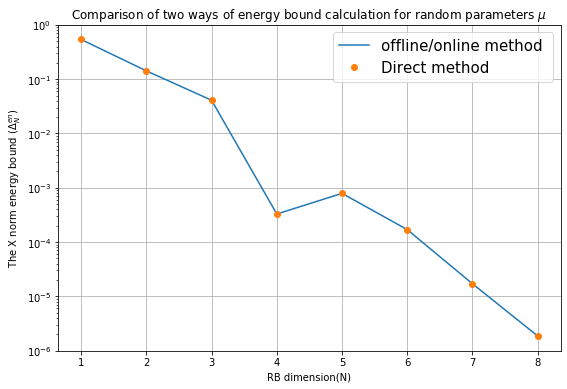

In [13]:
FE_RB_comparison.plot_delta_comparison()

**Comment:**

We conclude, that estimations produced by direct calculation and by offline/online estimation are identical, so it is recommended to use the one with less time consumption. Obviously, the direct method is $O(\cal N)$ so it should indeed be used only for verification as the offline/online methode is $O(Q^2N^2)$ (online stage) and then quicker.


### Sub-question (b)

Calculate $\eta^{en}_{min,N}(\mu)$, $\eta^{en}_{max,N}(\mu)$ and $\eta^{en}_{ave,N}(\mu)$ the minimum, maximum, and average effectivity $\eta^{en}_{min,N}(\mu)$ over:
$$\Xi^{test} = G^{lin}[\mu_{min}, \mu_{max}; 50] \cup G^{ln}[\mu_{min}, \mu_{max}; 50]$$
(note that $\Xi^{test}$ is of size 100 since P = 1).
Present the results in a table for all N . Is the minimum effectivity greater than unity? How does the maximum effectivity compare with your theoretical upper bound for the effectivity? (Note you should exclude from the min/max/mean operation all points in $\Xi^{test}$ for which ${{\left\Vert u(\mu)−u_N (\mu)\right\Vert}_X}$ is less than (say) 10e−11.)

To implement such study, we used the method `effectivity_min_max_ave(tol=10e-11,output =False)` in the class above `RB_PB3`. The method has the tolerance of the exact error as parameter and the type of the test sample $(linspace \cup log)$. The results of the effectivity are compared below.

**Note:**
    
The calculated energy effectivity is obtained by:
$$ \eta^{en}_N  = \frac {\Delta^{en}_N }{\mid \lVert e \rVert \mid}_{\mu} $$

One have to avoid the error to mix up the energy norm with inner norm!

In fact using:

$${\mid \lVert e \rVert \mid}_{\mu} = \sqrt {a(e,e,\mu)}$$ 

and not:

$${\mid \lVert e \rVert \mid}_{\mu} \neq \sqrt {a(e,e, \bar \mu)} =  {\lVert e \rVert}_{X}$$ 



**Precision = 10e-7:**

In [36]:
b = RB_PB3(test_max=50,grid ='linlog')
theo, cal = b.effectivity_min_max_ave(tol=10e-7)
print("effectivity max ave min theoritical is: \n", theo,"\n effectivity max ave min calculated is \n", cal)

effectivity max ave min theoritical is: 
 [1.0118171605283164, 1.398234978468973, 1.7506979520697898] 
 effectivity max ave min calculated is 
 [1.0066817171934053, 1.6517412603434656, 2.5339328848921316]


**Precision = 10e-18:**

In [37]:
b = RB_PB3(test_max=50,grid ='linlog')
theo, cal = b.effectivity_min_max_ave(tol=10e-18)
print("effectivity max ave min theoritical is: \n", theo,"\n effectivity max ave min calculated is \n",cal)

effectivity max ave min theoritical is: 
 [1.0118171605283164, 1.4367892411415766, 1.7782794100389228] 
 effectivity max ave min calculated is 
 [1.0066817171934053, 229750.50969241248, 11031123.15145068]


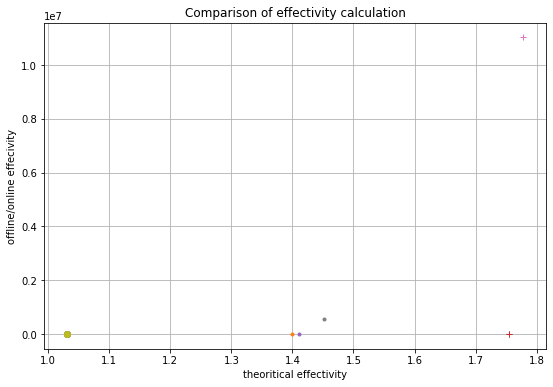

In [38]:
fig, ax = plt.subplots(figsize=(9,6))
for tol in [10e-7,10e-11,10e-18]:
    RB_test = RB_PB3(test_max=20,grid ='linlog')
    theo, cal = RB_test.effectivity_min_max_ave(tol=tol)
    ax.set(xlabel='theoritical effectivity', ylabel=r'offline/online effecivity', \
           title= r"Comparison of effectivity calculation")
    ax.plot(theo[2],cal[2],'+',label=r"max effectivity ")
    ax.plot(theo[1],cal[1],'.',label=r"ave effectivity ")
    ax.plot(theo[0],cal[0],'o',label=r"min effectivity")
    #ax.set_yscale('log')
    ax.grid(True)
#ax.legend(loc='best',fontsize=15);

**Comment:**
    
We notice that the effectivity lower bound is $\geq 1$ for any tolerance choice (i.e [10e-7,10e-11,10e-18]) but the average and the upper bound is only as expected for some tolerance choice. In fact, when the tolerance is `10e-18` for instance the average is not as expected but a bit bigger and even explosing for the upper bound. That comes in my opinion from the division by the tolerance wich imlies high values as long as it goes sharp. the choice of the tolerance is then a key parameter for the calculation of the effectivity.

### Sub-question (c)

Evalulate the effectivity for $\underline {\mu = 1}$ for $N = 1, . . . , 8.$ What do you observe?

In [52]:
for N in range(1,9):
    c = RB_PB3(N=N,test_max=50,grid ='mu_bar')
    theo, cal = c.effectivity_min_max_ave(tol=10e-8)
    #print("For N = ", N,"\n The ratio of the theritical effectivity out of the calculated one for min ave and max estimation is: \n",\
        #np.array(theo)/np.array(cal))
    print("\n-----------------------------For N = ", N,"----------------------------\n")
    print("Calculated effectivity [min,ave,max] is : ",cal)


-----------------------------For N =  1 ----------------------------

Calculated effectivity [min,ave,max] is :  [1.0000000000000038, 1.0000000000000038, 1.0000000000000038]

-----------------------------For N =  2 ----------------------------

Calculated effectivity [min,ave,max] is :  [1.0000000000000149, 1.0000000000000149, 1.0000000000000149]

-----------------------------For N =  3 ----------------------------

Calculated effectivity [min,ave,max] is :  [1.0000000000001228, 1.0000000000001228, 1.0000000000001228]

-----------------------------For N =  4 ----------------------------

Calculated effectivity [min,ave,max] is :  [1.0000000000026505, 1.0000000000026505, 1.0000000000026505]

-----------------------------For N =  5 ----------------------------

Calculated effectivity [min,ave,max] is :  [1.000000000022087, 1.000000000022087, 1.000000000022087]

-----------------------------For N =  6 ----------------------------

Calculated effectivity [min,ave,max] is :  [1.00000000145

**Observation:**

The calculated effectivity is $\sim 1$ for all value of N when the evaluation is on the inner product parameter $\bar \mu$.

**Justification:**

It is almost the same value for the theoritical estimation of the effectivity and the one calculated based on the offline/online method. This result is expected `mu_bar` is a parameter of the X inner product then $\alpha = \gamma = 1$. in particular $\alpha_{LB}$ and $\gamma_{UB}$.

In fact:

$$ \eta^{en}_N(\bar \mu)  = \frac {\Delta^{en}_N}{{\mid \lVert e \rVert \mid}_{\bar \mu}} = \frac {\frac {\epsilon_N(\bar \mu)}{\sqrt {\alpha_{LB}=1}}}{{\mid \lVert e \rVert \mid}_{\bar \mu}} = \frac {\epsilon_N(\bar \mu)}{{\lVert e \rVert}_{X}}
=\frac {{\lVert r(U_N(\bar \mu),v,\bar \mu) \rVert}_{X'}}{{\lVert e \rVert}_{X}}
$$

We use the fact that:

$${\lVert r(U_N(\bar \mu),v,\bar \mu) \rVert}_{X'} = {\lVert a(U_N(\bar \mu),v,\bar \mu) - l(v) \rVert}_{X'}
=
{\lVert a(U_N(\bar \mu),v,\bar \mu) - a(U_{exact}(\bar \mu),v,\bar \mu) \rVert}_{X'}
=
{\lVert a(U_N(\bar \mu)-U_{exact},v,\bar \mu) \rVert}_{X'}
$$

Then the `Rietz` reprensenter of $a(U_N(\bar \mu)-U_{exact},v,\bar \mu)$ allow as to say that:

$$
{\lVert a(U_N(\bar \mu)-U_{exact},v,\bar \mu) \rVert}_{X'} = 
{\lVert U_N(\bar \mu)-U_{exact} \rVert}_{X}=
{\lVert e \rVert}_{X}
$$

Then we conclude that:

$$ \eta^{en}_N(\bar \mu) = 1 $$


### Sub-question (d)

**Energy error bound:**

In [53]:
for N in range(1,9):
    d = RB_PB3(N=N)
    d.mu = [0.1,0.1,0.1,0.1,1,0.1]
    d.offline_decomposition()
    delta_en_N = c.online_decomposition()
    print("The energy error bound for N = ",N,"is: \t ",delta_en_N)

The energy error bound for N =  1 is: 	  1.7579537894552005e-05
The energy error bound for N =  2 is: 	  1.7579537894552005e-05
The energy error bound for N =  3 is: 	  1.7579537894552005e-05
The energy error bound for N =  4 is: 	  1.7579537894552005e-05
The energy error bound for N =  5 is: 	  1.7579537894552005e-05
The energy error bound for N =  6 is: 	  1.7579537894552005e-05
The energy error bound for N =  7 is: 	  1.7579537894552005e-05
The energy error bound for N =  8 is: 	  1.7579537894552005e-05


**Exact error:**

In [54]:
for N in range(1,9):
    d = RB_PB3(N=N)
    d.mu = [0.1,0.1,0.1,0.1,1,0.1]
    d.offline_decomposition()
    delta_en_N = c.online_decomposition()
    print("The exact error for N = ",N,"is: \t ",c.e)

The exact error for N =  1 is: 	  1.7579513745253586e-05
The exact error for N =  2 is: 	  1.7579513745253586e-05
The exact error for N =  3 is: 	  1.7579513745253586e-05
The exact error for N =  4 is: 	  1.7579513745253586e-05
The exact error for N =  5 is: 	  1.7579513745253586e-05
The exact error for N =  6 is: 	  1.7579513745253586e-05
The exact error for N =  7 is: 	  1.7579513745253586e-05
The exact error for N =  8 is: 	  1.7579513745253586e-05


In [47]:
theo, cal = d.effectivity_min_max_ave(tol=10e-8)
print("\n-----------------------------For N = ", N,"----------------------------\n")
print("Calculated effectivity [min,ave,max] is : ",cal)


-----------------------------For N =  8 ----------------------------

Calculated effectivity [min,ave,max] is :  [1.0000013801186654, 1.569728521427545, 2.2883379905822174]


**Observation:**
The exact error and the error bound are the same when evaluating at $\mu = 0.1$.

**Justification:**

$\mu = 0.1$ is a training point of the RB basis, so $U_N(\mu) \sim U_exact(\mu)$

Then: $$ \alpha_{LB}(0.1) = \frac {a(U_N(0.1)-U_{exact}(0.1),U_N(0.1)-U_{exact}(0.1),0.1)} {{ \lVert {{U_N(0.1)-U_{exact}(0.1)} \rVert}_X }^2} $$

We use the fact that:

$$ \epsilon_N(0.1) = {\lVert r(U_N(0.1),v,0.1) \rVert}_{X'} = {\lVert a(U_N(0.1),v,0.1) - l(v) \rVert}_{X'}
=
{\lVert a(U_N(0.1),v,0.1) - a(U_{exact}(0.1),v,0.1) \rVert}_{X'}
=
{\lVert a(U_N(0.1)-U_{exact},v,0.1) \rVert}_{X'}
$$

Then the `Rietz` reprensenter of $a(U_N(0.1)-U_{exact},v,0.1)$ allow as to say that:

$$
\epsilon_N(0.1) = {\lVert a(U_N(0.1)-U_{exact},v,0.1) \rVert}_{X'} = 
{\mid \lVert U_N(0.1)-U_{exact} \rVert \mid}_{0.1}= \sqrt {a(U_N(0.1)-U_{exact}(0.1),U_N(0.1)-U_{exact}(0.1),0.1)}
$$


we conclude then for the energy bound:
$$
\Delta^{en}_N = \frac {\epsilon_N(0.1)}{\sqrt {\alpha_{LB}(0.1)}} = {\lVert U_N(0.1)-U_{exact} \rVert }_{X}
$$

## Question 4: (case II)

**We consider Case II**. To answer this question you should use the sample set SN
provided for the PS2 (RB_sample.sample3), orthonormalize the basis functions,
and use the medium grid.

### Sub-question (a):

Implement an offline/online version of the a posteriori error bound calculation following the computational decomposition shown in the lecture. Show that
the direct calculation and the offline-online decomposition deliver the same results for the error bound, $∆^{en}_N(µ)$, for all $N (1 ≤ N ≤ 46)$ and (say) 5 parameter
values randomly distributed in D.

In [56]:
Q4_a = RB_PB3(1,6,2,'medium')
offon_delta, direct_delta = Q4_a.energy_bound_comparison(2,47)

Comparison done successfully!! outputs are respectively: offline/online, direct!


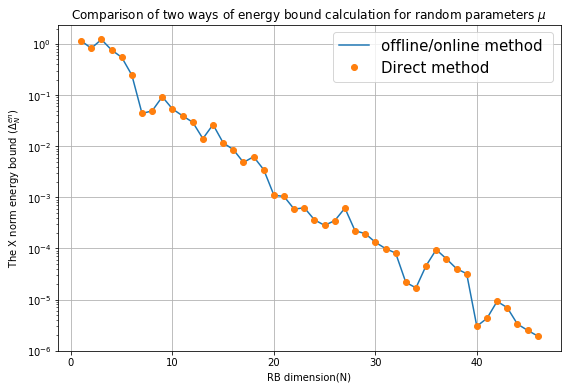

In [57]:
Q4_a.plot_delta_comparison()

**Comment:**

Still both methods gives the same results but we only use the direct one to debug. In fact, the offline/online decomposition is quicker especially for such big number of basis (i.e. N=46).

### Sub-question (b):

In [63]:
for N in [5,10,20,30,40]:
    Q4_b = RB_PB3(N=N,P=2,test_max=10,grid ='linlog')
    theo, cal = Q4_b.effectivity_min_max_ave(tol=10e-11)
    #print("For N = ", N,"\n Expected effectivity / Calculated effectivity is: \n",\
        #np.array(theo)/np.array(cal))
    print("\n------------------For N = ",N,"----------------------\n")
    print("The min ave max calculated effectivity = ",np.array(cal))
    print("The min ave max expected effectivity = ",np.array(theo))


------------------For N =  5 ----------------------

The min ave max calculated effectivity =  [1.01725537 2.11488538 6.68508336]
The min ave max expected effectivity =  [1.04663514 1.84083389 3.07147866]

------------------For N =  10 ----------------------

The min ave max calculated effectivity =  [1.03108208 2.1895857  6.90671849]
The min ave max expected effectivity =  [1.04663514 1.84116806 3.07147866]

------------------For N =  20 ----------------------

The min ave max calculated effectivity =  [1.05364219 2.20390894 6.89634055]
The min ave max expected effectivity =  [1.04663514 1.83930965 3.07147866]

------------------For N =  30 ----------------------

The min ave max calculated effectivity =  [1.0540032  2.06388605 7.03240197]
The min ave max expected effectivity =  [1.04663514 1.83930965 3.07147866]

------------------For N =  40 ----------------------

The min ave max calculated effectivity =  [ 1.04399323  2.09896351 10.18908614]
The min ave max expected effectivity =

**Results:**

The reults are presented for both expected and calculated output error bound.

$$for: \, \, tol= 10e-11, Calculated \, \, effectivity $$        

$$
\begin{array}{|l|c|c|c|c|c|}
\hline
\text{N} & 5 & 10 & 20 & 30 & 40 \\
\hline
\text{$\eta_{cal}^{min}$} & 1.01725537 & 1.03108208 & 1.05364219 & 1.0540032 & 1.04399323 \\
\hline
\text{${\eta_{cal}^{ave}}$} & 2.11488538  & 2.1895857 & 2.20390894 & 2.06388605 & 2.09896351 \\
\hline
\text{${\eta_{cal}^{max}}$} & 6.68508336 & 6.90671849 & 6.89634055 & 7.03240197 & 10.18908614 \\
\hline
\end{array}
$$
And the expected results table:
$$for: \, \, tol= 10e-11, Expected \, \, effectivity$$
$$
\begin{array}{|l|c|c|c|c|c|}
\hline
\text{N} & 5 & 10 & 20 & 30 & 40 \\
\hline
\text{$\eta_{expected}^{min}$} & 1.04663514 & 1.04663514  & 1.04663514 & 1.04663514 & 1.04663514 \\
\hline
\text{${\eta_{expected}^{ave}}$} & 1.84083389 & 1.84116806 & 1.83930965 & 1.83930965 & 1.83930965 \\
\hline
\text{${\eta_{expected}^{max}}$} & 3.07147866 & 3.07147866 & 3.07147866 & 3.07147866 & 3.07147866\\
\hline
\end{array}
$$



**Observation:**

The results does not change for all values of N for the expected effectivity. The calculated effectivity is almost the same for both the average and the minimum estimation but getting higher for the maximum estimated value when N is big. 

**Justification:**
As long as the diemnsion of the RB is big as ${{\mid \lVert U_N-U \rVert \mid}_{\bar \mu}}$ is smaller and thus the effectivity is bigger.

# Part 3 - Reduced Basis Output Bound (case II)

**We consider Case II**. To answer this question we should use the sample set SN
provided for PS2 (RB_sample.sample3), orthnormalize the basis functions, and
use the medium grid.

## Question 5: (output effectivity)

### Sub-question (a):

The calculation is included in the class above `RB_PB3` in the method `effectivity_min_max_ave()`.

The implementation of the output error bound is based on the following formulas:

$$\Delta_{N}^s(\mu) = {\Delta_{N}^{en}(\mu) }^2$$
And thus the effectivity:
$$\eta_{N}^s(\mu) = \frac {\Delta_{N}^s(\mu)}{s(\mu)-s_N(\mu)}$$

Also from the lecture, the theoritical bounds are given by:

$$1 \leq \eta^s_N(\mu) \leq {\frac{\gamma_{UB}}{\alpha_{LB}}} \quad \quad (24)$$

In [64]:
Q5_a = RB_PB3(N=8,Q=6,P=2,triangulation ='medium',test_max = 5,grid ='linlog')
Q5_a.effectivity_min_max_ave(tol=10e-9)
print("min ave max output energy bound",Q5_a.eta_s_min_ave_max_calc)

min ave max output energy bound [0.9999999999993272, 5.906560226169085, 38.28493101969902]


### Sub-question (b):

Calculate $\eta^{s}_{min,N}(\mu)$, $\eta^{s}_{max,N}(\mu)$ and $\eta^{s}_{ave,N}(\mu)$ the minimum, maximum, and average effectivity $\eta^{s}_{min,N}(\mu)$ over:
$$\Xi^{test} = G^{lin}[\mu_{min}, \mu_{max}; 10] \cup G^{ln}[\mu_{min}, \mu_{max}; 10]$$.
Present the results in a table for all N . 

In [65]:
for N in [5,10,20,30,40]:
    Q5_b = RB_PB3(N=N,Q=6,P=2,triangulation ='medium',test_max = 10,grid ='linlog')
    Q5_b.effectivity_min_max_ave(tol=10e-11,output=True)
    print("output energy bound",Q5_b.eta_s_min_ave_max_calc)
    print("output energy bound expected ",Q5_b.eta_s_min_ave_max_theo)
    print("------------------------------------------------------")

output energy bound [1.0348084920497902, 5.4195659263140845, 44.690339151709836]
output energy bound expected  [1.0954451150103324, 3.388669422603848, 9.433981132056605]
------------------------------------------------------
output energy bound [1.063130249799135, 6.038933316207135, 47.70265970499562]
output energy bound expected  [1.0954451150103324, 3.3898998126170836, 9.433981132056605]
------------------------------------------------------
output energy bound [1.110161855131382, 4.788961139930416, 21.554471244324702]
output energy bound expected  [1.0954451150103324, 3.1989321461659497, 9.433981132056603]
------------------------------------------------------
output energy bound [1.1109229014488173, 3.740487237520514, 19.87586126487164]
output energy bound expected  [1.0954451150103324, 2.926975397501325, 7.74263682681127]
------------------------------------------------------
output energy bound [1.0899266519152402, 2.1678761941698306, 4.6754001284841]
output energy bound expected

**Results:**

The reults are presented for both expected and calculated output error bound.

$$for: \, \, tol= 10e-11, Calculated \, \, output \, \, energy \, \, bound $$
$$
\begin{array}{|l|c|c|c|c|c|}
\hline
\text{N} & 5 & 10 & 20 & 30 & 40 \\
\hline
\text{$\eta_{cal}^{min}$} & 1.03 & 1.06& 1.11 & 1.11 & 1.08 \\
\hline
\text{${\eta_{cal}^{ave}}$} & 5.41  & 6.03 & 4.78 & 3.74 & 2.16 \\
\hline
\text{${\eta_{cal}^{max}}$} & 44.92 & 47.70 & 21.55 & 19.87 & 4.67 \\
\hline
\end{array}
$$
And the expected results table:
$$for: \, \, tol= 10e-11, Expected \, \, output \, \, energy \, \, bound$$
$$
\begin{array}{|l|c|c|c|c|c|}
\hline
\text{N} & 5 & 10 & 20 & 30 & 40 \\
\hline
\text{$\eta_{expected}^{min}$} & 1.09 & 1.09 & 1.09 & 1.09 & 1.09 \\
\hline
\text{${\eta_{expected}^{ave}}$} & 3.38 & 3.38 & 3.19 & 2.92 & 1.87 \\
\hline
\text{${\eta_{expected}^{max}}$} & 9.43 & 9.43 & 9.43 & 7.74 & 2.94\\
\hline
\end{array}
$$


**Observation:**

The minimum output effectivity is as expected but still the average and the maximum output effectivity not the same. The maximum output effectivity is getting closer to the expected one as long as N get bigger. The average can be a good approximation of the output effectivity as shown in the table above.

### Sub-question (c):

**What value of N do we require to achieve a relative accuracy in the output
bound of approximately 1%?**

The relative output error bound can be expressed as follows:

$${\Delta_N}^{s,rel}(\mu) = \frac {{\Delta_N}^{s}(\mu)}{S_N(\mu)} $$

It was implemted in the class `RB_PB3` in its method: `effectivity_min_max_ave()`.

In [66]:
for N in range(1,47):
    Q5_c = RB_PB3(N=N,Q=6,P=2,triangulation ='medium',test_max = 10,grid ='linlog')
    Q5_c.effectivity_min_max_ave(tol=10e-11,output=True)
    relative_error_max = Q5_c.relative_output_error_min_ave_max_calc[2]
    if (relative_error_max <= 0.01):
        print("------------------------------------------------------------------------------------------------")
        print("To achieve a relative accuracy in the output bound (max) of approximately 1% we need N = ",N)
        print("------------------------------------------------------------------------------------------------\n")
        print('This corresponds to a relative output error bounds: \n [min,ave,max]=', Q5_c.relative_output_error_min_ave_max_calc)
        break
    else:
        print("we only reached ", relative_error_max * 100,"% for N =", N)

we only reached  22072.4564728229 % for N = 1
we only reached  509.549370532427 % for N = 2
we only reached  525.9479213960115 % for N = 3
we only reached  277.6495850847265 % for N = 4
we only reached  287.6143636875867 % for N = 5
we only reached  273.26332801036494 % for N = 6
we only reached  3.091790973430663 % for N = 7
we only reached  4.506931863439113 % for N = 8
we only reached  4.106387323826537 % for N = 9
------------------------------------------------------------------------------------------------
To achieve a relative accuracy in the output bound (max) of approximately 1% we need N =  10
------------------------------------------------------------------------------------------------

This corresponds to a relative output error bounds: 
 [min,ave,max]= [1.7290381988907638e-07, 0.002113710543997183, 0.0073991072755460185]


**What is the true error for this value of N ?**

The true error is already implemented as $S(\mu)-S_N(\mu)$. For N = 10 we have then:

In [67]:
Q5_c = RB_PB3(N=N,Q=6,P=2,triangulation ='medium',test_max = 10,grid ='linlog')
Q5_c.effectivity_min_max_ave(tol=10e-11,output=True)
True_error_output = Q5_c.erreur_root
print("----------------------------------------------------------------------------------")
print("We reach a true output error of ", True_error_output,"for N =", N)
print("----------------------------------------------------------------------------------")

----------------------------------------------------------------------------------
We reach a true output error of  2.5579538487363607e-13 for N = 10
----------------------------------------------------------------------------------


**Comment:**
    
Both the relative and the true errors seem satisfying! especially that the number N is not very expensive.

### Sub-question (d):

**How does the online computational cost to calculate $∆^s_N (µ)$ compared to the online computational cost to calculate $s_N (µ)$ as a function of N?**(we take the
average over the test sample $\Xi^{test}_M$ )

The used function is **time.process_time_ns() → int (at least Python3.3)** which
returns the value (in fractional seconds) of the sum of the system and user CPU time of the current process. It does not include time elapsed during sleep. It is process-wide by definition. The reference point of the returned value is undefined, so that only the difference between the results of consecutive calls is valid. **This means that other processes running on the same computer does not interfere with the timing**.

Regarding the implementation, the time measurement were set in the main class `RB_PB3` inside its method `effectivity_min_max_ave()`. The results are presented in the cell below:

**Estimation of cpu time:**

In [68]:
SN_cpu_avg = []
delta_s_cpu_avg = []
N_max = 47
for N in range(1,N_max):
    Q5_d = RB_PB3(N=N,Q=6,P=2,triangulation ='medium',test_max = 10,grid ='linlog')
    Q5_d.effectivity_min_max_ave(tol=10e-11,output=True)
    SN_cpu_avg.append(Q5_d.SN_CPU)
    delta_s_cpu_avg.append(Q5_d.delta_s_CPU)

**Plot:**

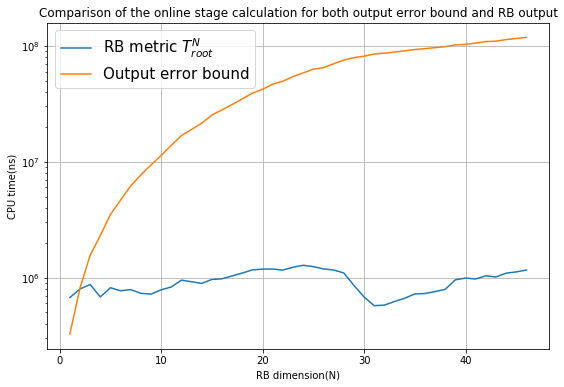

In [69]:
fig, ax = plt.subplots(figsize=(9,6))
ax.set(xlabel='RB dimension(N)', ylabel='CPU time(ns)', \
       title= "Comparison of the online stage calculation for both output error bound and RB output")
ax.plot(range(1,N_max),SN_cpu_avg,label=r"RB metric $T_{root}^N$ ")
ax.plot(range(1,N_max),delta_s_cpu_avg,label=r"Output error bound")
ax.set_yscale('log')
ax.grid(True)
ax.legend(loc='best',fontsize=15);

**Comment:**
The calculation of the online output error bound can be expansive for high RB dimensions, while the RB online output is almost steady for all N. 

### Sub-question (e):

The same question but including the true output solution calculation to the previous comparison. estimation of the cpu time was implemented as described in the former question.

**Estimation of cpu time:**

In [312]:
SN_cpu_avg = []
S_cpu_avg = []
delta_s_cpu_avg = []
N_max = 47
for N in range(1,N_max):
    Q5_e = RB_PB3(N=N,Q=6,P=2,triangulation ='medium',test_max = 10,grid ='linlog')
    Q5_e.effectivity_min_max_ave(tol=10e-11,output=True)
    SN_cpu_avg.append(Q5_e.SN_CPU)
    S_cpu_avg.append(Q5_e.S_CPU)
    delta_s_cpu_avg.append(Q5_e.delta_s_CPU)
    

**Plot:**

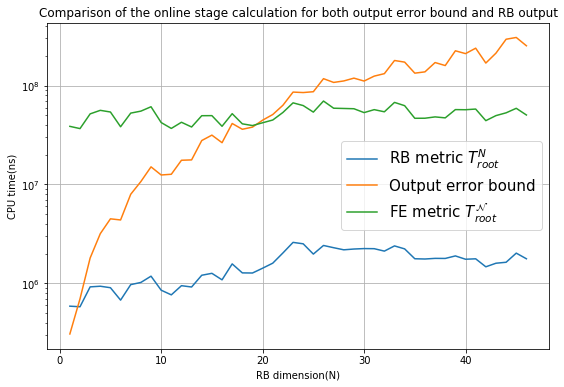

In [314]:
fig, ax = plt.subplots(figsize=(9,6))
ax.set(xlabel='RB dimension(N)', ylabel='CPU time(ns)', \
       title= "Comparison of the online stage calculation for both output error bound and RB output")
ax.plot(range(1,N_max),SN_cpu_avg,label=r"RB metric $T_{root}^N$ ")
ax.plot(range(1,N_max),delta_s_cpu_avg,label=r"Output error bound")
ax.plot(range(1,N_max),S_cpu_avg,label=r"FE metric $T_{root}^{\cal N}$ ")
ax.set_yscale('log')
ax.grid(True)
ax.legend(loc='best',fontsize=15);

**Comment:**

The cost of both FE and RB outputs is constant, while the cost of the online output error bound is raising with  the dimension of the RB. still it is less than the calculation of the FE output solution. Which makes the true output error a bad criteria for convergeance. In fact, it is less expansive to check the relative output error bound especially for small dimensions of the RB (e.g less than 20)

# Part 4 - Greedy Sampling Procedure

The offline-online computational decomposition for the reduced basis approximation and associated a posteriori error estimation is tested and functioning. We now turn to the Greedy Sampling Procedure. The purpose is thus constructing the sample ourselves.

For this problem set, we use the algorithm with:
$$ω(\mu) = |||u_N (\mu)|||_{\mu}$$

(note that we can calculate $|||u_N (\mu)|||_{\mu}$ online-efficient in $O(N^2)$ operations— as opposed to $|||u (\mu)|||_{\mu}$ which would require $O(\cal N)$ operations). 

We set the desired error tolerance to $ε_{{tol},{min}} = 10e-6$ and choose $S1 = \mu_{min}$ and $X_1 = span \text{{ $u(\mu_{min})$ }}$.

Note that there are many steps implicit in the greedy loop. In particular, after the update $S_N = S_{N−1} ∪ \mu^*_N$ we must calculate $u (\mu^*_N)$ to construct (using Gram-Schmidt) the new contribution to our orthonormal basis set, $\xi_N$,to “form” $X_N$ , and finally calculate all the necessary online quantities for both
our reduced basis approximation and associated a posteriori error estimation.

We note here a practical point for our hierarchical space: as we proceed from N to N + 1, we should only compute the necessary incremental quantities — the incremental contributions to the various online inner-product arrays required for the reduced basis approximation and a posteriori error estimators.

The following class is the implementation of the greedy sampling procedure within the part 4. it is followed by some tests and the answer of the questions are presented afterwards.

In [801]:
class RB_PB3_greedy:
    
    def __init__(self,Nmax=8,Q=6,P=1,triangulation ='medium',train_max = 100,grid ='linlog',test_max = 50):
        self.Nmax = Nmax #maximum RB dimension 
        self.Q = Q #number of parameters
        self.case = P #case 1 or case 2
        self.triangulation = triangulation #'coarse', 'medium' or 'fine'
        self.train_max = train_max
        self.test_max = test_max
        self.grid = grid
        
        '''othonormalized RB'''
        self.Z_ort = None
        
        '''train sample'''
        self.E_train_ln = None
        self.S1 = [[0.1,0.1]] if (self.case == 1) else [[0.1,0.01]]
        self.delta_out_max_list = []
        self.max_rel_error_enorm_list = []
        self.max_erreur_root_list = []
        
        self.Lqn = None#np.zeros((self.Q,self.Nmax,self.N_cal))
        self.C_Lqn_X = None#np.zeros((self.Q,self.Nmax))
        self.Lqn_lqn_X = None#np.zeros((self.Q,self.Nmax,self.Q,self.Nmax))
        
        self.N_cal = None #dimention of FE space
        self.Aq_mesh = None # FE matrix independant of parameters
        self.Fh_mesh = None # FE second term
        self.A_mu_bar = None #X inner product associated matrix
        self.mu_bar = None #mu bar of the X inner product
        self.mu_sample = None#training
        self.Bi = None #training
        self.mu = None #evaluation
        
    def inner_prod_A(self,u,v):
        return u.T@self.A_mu_bar@v
    
    def assembleA(self,mu,Aq):
        A=csc_matrix(np.shape(Aq[0]))
        for k in range(0,6):
            A+=mu[k]*Aq[k]
        return A
    
    def Gram_Schmidt_inplace(self,A,u,i):
        v = u.copy()
        for k in range(i):
            v[:,i]-=self.inner_prod_A(u[:,i],u[:,k])*u[:,k]
        v[:,i] = v[:,i]/np.sqrt(self.inner_prod_A(v[:,i],v[:,i]))
        return v[:,i]
        
    def load_matrices_samples(self):
        M = loadmat('FE_matrix.mat',simplify_cells=True)
        self.Aq_mesh=M['FE_matrix'][self.triangulation]['Ahq']
        self.Fh_mesh=M['FE_matrix'][self.triangulation]['Fh']
        
        grids = loadmat('FE_grid.mat',simplify_cells=True)
        self.N_cal = grids['FE_grid'][self.triangulation]['nodes']
        
        self.Z_ort = np.zeros((self.N_cal,self.Nmax))
        
        '''A and mu bar for inner product'''
        self.mu_bar=np.array([1,1,1,1,1, 0.1])
        
        self.A_mu_bar = self.assembleA(self.mu_bar,self.Aq_mesh)
        
        '''solve C and forming (C,C)_X'''
        C = spsolve(self.A_mu_bar,self.Fh_mesh)
        self.C_C_X = self.inner_prod_A(C,C)
        self.C = C
        
        '''form Lqn ...'''

        self.Lqn = np.zeros((self.Q,self.Nmax,self.N_cal))
        self.C_Lqn_X = np.zeros((self.Q,self.Nmax))
        self.Lqn_lqn_X = np.zeros((self.Q,self.Nmax,self.Q,self.Nmax))
        
        '''samples'''
        self.prepare_train_test_samples()
    
    def prepare_train_test_samples(self):
        
        '''training samples for case 1 and 2'''
            
        if self.case == 1:
            sample = np.array([np.exp(np.linspace(np.log(0.1), np.log(10), self.train_max))\
                                        ,0.1*np.ones(self.train_max)])
            
            
            self.E_train_ln = np.zeros((self.train_max,2))
            self.E_train_ln[:,0] = sample[0]
            self.E_train_ln[:,1] = sample[1]
            
        else:
            sample = np.array([np.exp(np.linspace(np.log(0.1), np.log(10), self.train_max))\
                                        ,np.exp(np.linspace(np.log(0.01), np.log(1), self.train_max))])

            '''all combinations ki and Bi'''    
            x, y = np.meshgrid(sample[0], sample[1])
            X = x.flatten()
            Y = y.flatten()
            
            self.E_train_ln = np.zeros((len(X),2))
            self.E_train_ln[:,0] = X[:]
            self.E_train_ln[:,1] = Y[:]
            
        
        if self.grid == 'linlog':
            if self.case==1:
                sample = np.array([np.concatenate((np.linspace(0.1,10,self.test_max),\
                                  np.exp(np.linspace(np.log(0.1), np.log(10), self.test_max)))),\
                                       0.1*np.ones(2*self.test_max)])
                
                self.E_test_lin_ln = np.zeros((2*self.test_max,2))
                self.E_test_lin_ln[:,0] = sample[0]
                self.E_test_lin_ln[:,1] = sample[1]
            else:
                
                
                sample = np.array([np.concatenate((np.linspace(0.1,10,self.test_max),\
                                  np.exp(np.linspace(np.log(0.1), np.log(10), self.test_max)))),\
                                  np.concatenate((np.linspace(0.01,1,self.test_max),\
                                  np.exp(np.linspace(np.log(0.01), np.log(1), self.test_max))))])
                
                '''all combinations ki and Bi'''    
                x, y = np.meshgrid(sample[0], sample[1])
                X = x.flatten()
                Y = y.flatten()
                
                self.E_test_lin_ln = np.zeros((len(X),2))
                self.E_test_lin_ln[:,0] = X[:]
                self.E_test_lin_ln[:,1] = Y[:]
                
        else:
            pass

        
        
    def offline_calculation_RB(self,i):
        

        Z_ort = self.Z_ort[:,:i].copy()
        
        mu_init = self.S1[-1]
        
        
        self.Aq = np.ndarray((self.Q,i,i))
        self.Fh = np.zeros(i)
        
        #calculation of orthonormalized Z
        mu=np.array([mu_init[0],mu_init[0], mu_init[0],mu_init[0],1, mu_init[1]])

        A=self.assembleA(mu,self.Aq_mesh)
        u = spsolve(A, self.Fh_mesh)
        self.Z_ort[:,i-1] = u[:]
        self.Z_ort[:,i-1] = self.Gram_Schmidt_inplace(A,self.Z_ort[:,:i],i-1)
        
        Z_ort = self.Z_ort[:,:i].copy()
        
        #print("---------constructed basis for iteration: ",i," is -------------- \n",Z_ort)
        
        for i in range(self.Q):
            self.Aq[i,:,:] = Z_ort.T @ self.Aq_mesh[i] @ Z_ort

        self.Fh = Z_ort.T @ self.Fh_mesh
        
    def calculate_rel_max_error(self,i,training_sample,Nmax=10):
        '''offline'''
        self.S1 = np.array([training_sample[i-1]])
        self.offline_calculation_RB(i)
        
        '''online'''
        self.rel_energy_norm_list = []
        self.erreur_root_list = []
        
        for mu_new in self.E_test_lin_ln:
            mu=np.array([mu_new[0],mu_new[0], mu_new[0],mu_new[0],1, mu_new[1]])
            
            '''u and UN'''
            #u
            A=self.assembleA(mu,self.Aq_mesh)
            u = spsolve(A, self.Fh_mesh)

            #UN->U_N
            A_N = self.assembleA(mu,self.Aq)
            UN = np.linalg.lstsq(A_N,self.Fh,rcond=None)[0]
            U_N = self.Z_ort[:,:i]@UN
            
            '''energy norm of relative error'''
            #energy norm
            UN_u = U_N - u
            energy_norm_UN_u = np.sqrt(UN_u@A@UN_u.T)
            energy_norm_u = np.sqrt(u@A@u.T)
            #relative error energy norm
            rel_energy_norm = energy_norm_UN_u/energy_norm_u
            self.rel_energy_norm_list.append(rel_energy_norm)
            
            '''relatuve output error '''
            T_root_N = self.Fh.T@UN
            T_root = self.Fh_mesh.T@u
            erreur_root = np.abs(T_root - T_root_N)/T_root
            self.erreur_root_list.append(erreur_root)
        #energy    
        self.max_rel_error_enorm = max(self.rel_energy_norm_list)
        self.max_rel_error_enorm_list.append(self.max_rel_error_enorm)
        
        #output
        self.max_erreur_root = max(self.erreur_root_list)
        self.max_erreur_root_list.append(self.max_erreur_root)
            
        
    def offline_decomposition(self,i):
        '''Z, Aq,Fh'''
        self.offline_calculation_RB(i)
        
        '''solve C and forming (C,C)_X'''
        C = self.C #stored when assembling the matrix
        C_C_X = self.C_C_X #stored when assembling the matrix
        
        n= i-1      
        
        '''solve Lnq'''
        Lqn = self.Lqn
        C_Lqn_X = self.C_Lqn_X
        for q in range(self.Q):
            #for n in range(i):
            Lqn[q,n,:] = spsolve(self.A_mu_bar, -self.Aq_mesh[q] @ self.Z_ort[:, n])[:]

        '''forming (C,Lqn)_X '''
        for q in range(self.Q):
            #for n in range(i):
            C_Lqn_X[q,n] = self.inner_prod_A(Lqn[q,n,:],C[:])
        

        '''forming (lq'n',lqn)_X'''
        Lqn_lqn_X = self.Lqn_lqn_X
        for q in range(self.Q):
            #for n in range(i):
            for p in range(self.Q):
                for m in range(i):
                    Lqn_lqn_X[q,n,p,m] = self.inner_prod_A(Lqn[q,n,:],Lqn[p,m,:])
         
        m= i-1
        '''forming (lq'n',lqn)_X'''
        Lqn_lqn_X = self.Lqn_lqn_X
        for q in range(self.Q):
            for n in range(i):
                for p in range(self.Q):
                    #for m in range(i):
                    Lqn_lqn_X[q,n,p,m] = self.inner_prod_A(Lqn[q,n,:],Lqn[p,m,:])

        '''saving'''
        self.C_C_X = C_C_X
        self.C_Lqn_X = C_Lqn_X
        self.Lqn_lqn_X = Lqn_lqn_X
        
        return self
        
    def online_decomposition(self,i):
        '''delta_en'''
        self.delta_en_N_list = []
        self.w_delta_list=[]
        self.rel_exact_error_list = []
        
        for mu_new in self.E_train_ln:
            
            mu=np.array([mu_new[0],mu_new[0], mu_new[0],mu_new[0],1, mu_new[1]])
            
            '''calculate UN and its energy norm'''
            A_N = self.assembleA(mu,self.Aq)
            #UN = np.linalg.solve(A_N,self.Fh) #return linalg error
            UN = np.linalg.lstsq(A_N,self.Fh,rcond=None)[0]
            energy_norm_UN = np.sqrt(UN@A_N@UN.T)

            delta_start = process_time_ns() #time start

            n=i-1
            ''''calculating ||Ê||²'''
            self.E_hat = self.C_C_X
            for q in range(self.Q):
                for n in range(i):
                    output = 2*self.C_Lqn_X[q,n]
                    for p in range(self.Q):
                        for m in range(i):
                            output += mu[p]*UN[m]*self.Lqn_lqn_X[q,n,p,m]
                    self.E_hat += mu[q]*UN[n]*output

            '''calculate x norme energy bound'''
            self.delta_en_N = np.sqrt(np.abs(self.E_hat/min(mu/self.mu_bar)))
            delta_stop = process_time_ns() 
            delta_time = delta_stop - delta_start#time stop SN
            #self.delta_s_CPU_list.append(delta_time)
            
            '''calculate relative exact error'''
            A=self.assembleA(mu,self.Aq_mesh)
            u = spsolve(A, self.Fh_mesh)
            U_N = self.Z_ort[:,:i]@UN
            self.rel_exact_error = np.sqrt(self.inner_prod_A(u-U_N,u-U_N))/energy_norm_UN[0,0]

            
            '''append the relative and absolute energy error bound'''
            self.delta_en_N_list.append(self.delta_en_N)
            to_add = self.delta_en_N/energy_norm_UN[0,0]
            self.w_delta_list.append(to_add)
            '''append the  relative exact error'''
            self.rel_exact_error_list.append(self.rel_exact_error)
            
        '''calculate new mu'''
        list_max = np.array(self.w_delta_list).flatten()
        mu_new_index = list_max.argmax()
        mu_new_ = self.E_train_ln[mu_new_index]
        self.S1.append(mu_new_)
        self.delta_out_max_list.append(self.delta_en_N_list[mu_new_index])
        
    
        return self.S1,self.delta_out_max_list
        
        
    def constructing_sample(self,tol=10e-6,plot=None):
        self.load_matrices_samples()
        
        '''initialization tol,S1 and basis Z1,'''
        offline = self.offline_decomposition(1)
        self.S1,self.delta_out_max_list =  offline.online_decomposition(1)
        self.delta_out_max = self.delta_out_max_list[-1]
        
        print("first value of delta_{max,en} is: ", self.delta_out_max)
        
        i = 2
        while (self.delta_out_max > tol):
            if plot == 'sequence':
                fig, ax = plt.subplots(figsize=(9,6))
                ax.set(xlabel='train sample', ylabel='Relative errors', \
                       title= "Relative energy and exact error bound over the train sample for RB dimension N = "+str(i))
                ax.plot(self.E_train_ln[:,0],self.delta_en_N_list,'.',label=r"$\frac {\Delta^{en}_{N}} {{\left \Vert U_N \right \Vert }_{\mu}}$ ")
                ax.plot(self.E_train_ln[:,0],self.rel_exact_error_list,'o',label=r"$\frac {{\left \Vert u-U_N \right \Vert }_X}{{\left \Vert U_N \right \Vert }_{\mu}}$")
                ax.plot(self.S1[-1][0]*np.ones(10),np.linspace(min(self.delta_en_N_list),max(self.delta_en_N_list),10),label=r" The picked $\mu^* = $"+str(self.S1[-1]))
                #ax.set_yscale('log')
                ax.grid(True)
                ax.legend(loc='best',fontsize=15);
            
            offline = self.offline_decomposition(i)
            self.S1,self.delta_out_max_list = offline.online_decomposition(i)
            self.delta_out_max = self.delta_out_max_list[-1]
            i = i + 1
            assert i < self.Nmax, "we have reached a maximum RB dimension without reaching the wanted precision!!"
            
            
        RB_N = i -1
        print("The RB dimension to reach a precision of",tol, " is: ",RB_N)
            
        if plot == 'overview':
            fig, ax = plt.subplots(figsize=(9,6))
            ax.set(xlabel='RB dimension (N)', ylabel='max ralative energy error bound', \
                   title= "Relative energy error bound over the RB dimension (N) according to the picked parameters")
            ax.plot(range(1,RB_N+1),self.delta_out_max_list,'.-',label=r"$\frac {\Delta^{en}_{max}}{||| U_N(\mu^*) |||}$ ")
            ax.plot(RB_N*np.ones(100),np.linspace(0,max(self.delta_out_max_list),100),label=r"The maximum RB dimension (Nmax = "+str(RB_N)+") ")

            ax.set_yscale('log')
            ax.grid(True)
            ax.legend(loc='best',fontsize=15);
            
            
        

In [792]:
def test_greedy(Nmax):
    test = RB_PB3_greedy(Nmax=Nmax,Q=6,P=1,triangulation ='medium',train_max = 5,grid ='linlog')
    test.load_matrices_samples()
    for i in range(1,Nmax):
        offline = test.offline_decomposition(i)
        offline.online_decomposition(i)
        
    print("--------",test.delta_out_max_list, test.S1 )   
    return test


test =test_greedy(5)
delta_out_max_list, S1  = test.delta_out_max_list, test.S1 
E_train,delta_en_N_list,w_delta_list,rel_exact_error_list = test.E_train_ln[0], test.delta_en_N_list,test.w_delta_list, test.rel_exact_error_list

-------- [1.3903745108064633, 0.22265728285599873, 0.03820862885498783, 0.009723623865385422] [[0.1, 0.1], array([10. ,  0.1]), array([1. , 0.1]), array([0.31622777, 0.1       ]), array([3.16227766, 0.1       ])]


In [717]:
def test_greedy_energy(Nmax,training_sample):
    test = RB_PB3_greedy(Nmax=Nmax,Q=6,P=1,triangulation ='medium',train_max = 5,grid ='linlog',test_max=5)
    test.load_matrices_samples()
    for i in range(1,Nmax):
        offline = test.offline_decomposition(i)
        offline.calculate_rel_max_error(i,training_sample,Nmax)
  
    return test


log_sample = np.zeros((10,2))
log_sample[:,0],log_sample[:,1] = np.exp(np.linspace(np.log(0.1), np.log(10), 10)),0.1

training_sample = log_sample
test =test_greedy_energy(5,training_sample)
test.max_rel_error_enorm_list

[0.9224059422739863,
 0.7626057716678348,
 0.5306946568109069,
 0.1750005813853592]

## Question 6:

We consider Case I. We apply the greedy algorithm with:

$\Xi^{train} = G^{lin}[\mu_{min}, \mu_{max}; 100]$, $S_1 = \mu_{min} = 0.1$ and $\epsilon_{ tol,min }= 1e-6$.

### Sub-question (a):

**What is the value of Nmax to achieve the desired accuracy?**

We use the class `RB_PB3_greedy` and its method `constructing_sample` which has apart from the tolerance another argument defining weither the plot is an `overview` of the obtained maximum relative energy error bound over the training sample or a `sequence` of plots descibing the evolution of the relatie energy error bound over the checked training sample.

**Note:**

In order to avoid the singular matrix error problem when one one of the matrices is not invertible, linalg.lstsq provides a usable solution.

first value of delta_{max,en} is:  1.3903745108064633
The RB dimension to reach a precision of 1e-06  is:  10


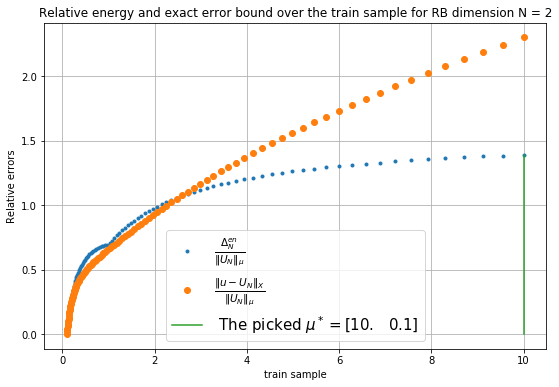

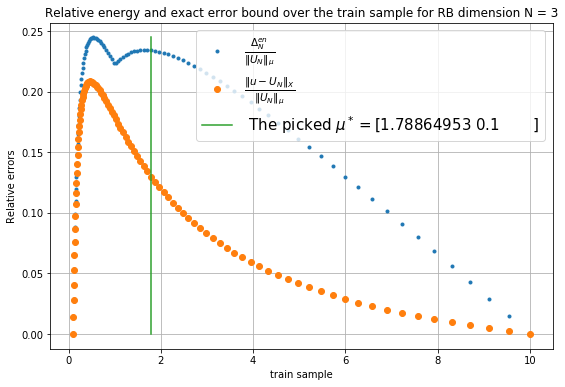

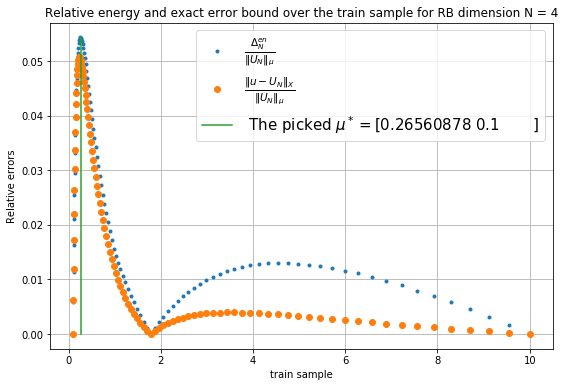

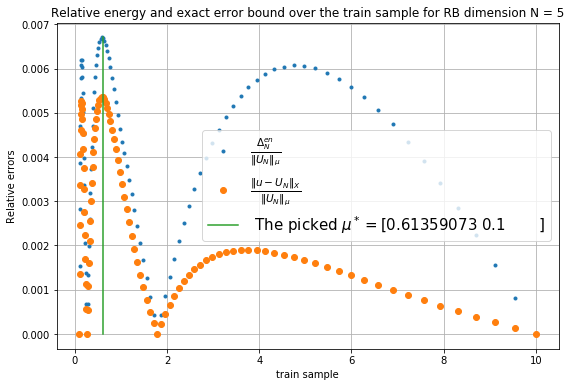

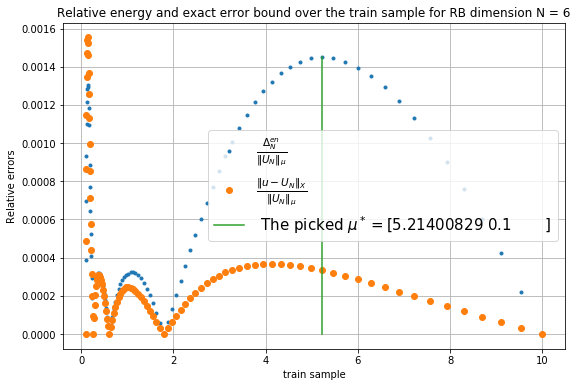

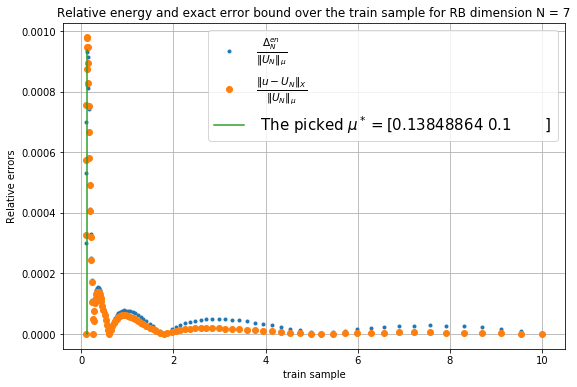

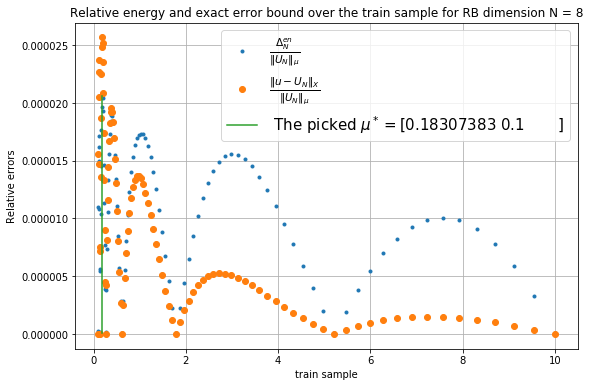

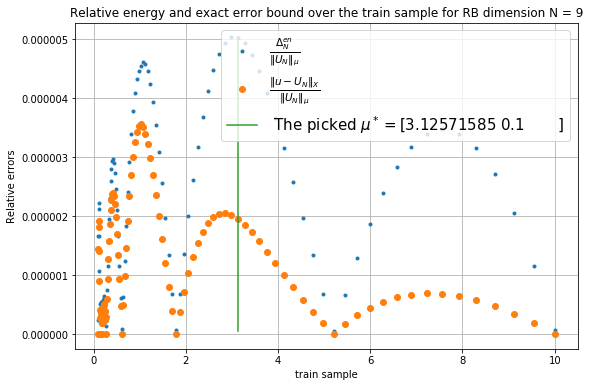

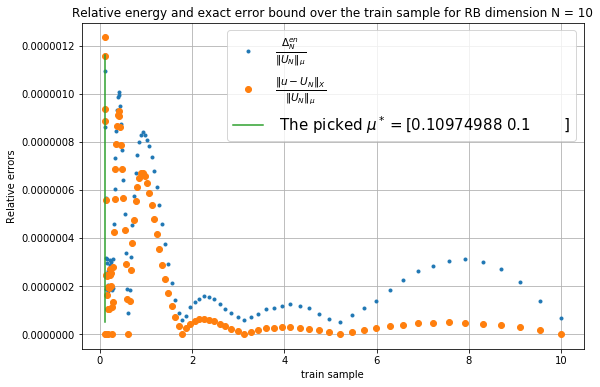

In [632]:
Q6_a = RB_PB3_greedy(Nmax=1000,Q=6,P=1,triangulation ='medium',train_max = 100,grid ='linlog')
Q6_a.constructing_sample(tol=1e-6,plot='sequence')

**Comment:**

For a precision of `1e-6`, we have a reduced basis of dimension equal to `10` !

**Observation:**

For the same precison, but equidistant training sample i obtained 9 as RB max dimension.

### Sub-question (b):

first value of delta_{max,en} is:  1.3903745108064633
The RB dimension to reach a precision of 1e-06  is:  10
CPU times: user 46.8 s, sys: 1.71 s, total: 48.5 s
Wall time: 16.4 s


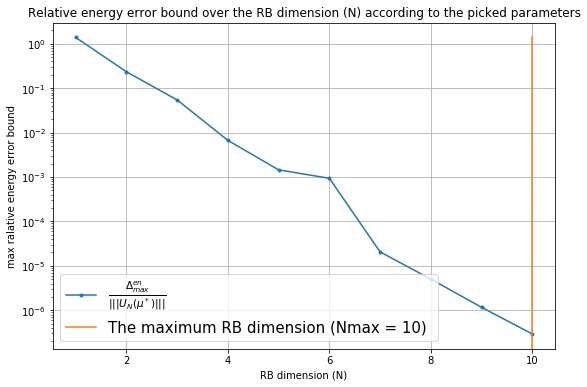

In [756]:
%%time
Q6_b = RB_PB3_greedy(Nmax=1000,Q=6,P=1,triangulation ='medium',train_max = 100,grid ='linlog')
Q6_b.constructing_sample(tol=1e-6,plot='overview')

**Comment:**

The maximum relative energy error bound is increasing with raising the number of dimension of the RB. The given precision of `1e-6` allow us to pick a parameter according to a worst scenario error which is acceptable

### Sub-question (c):

Givn that obtained hierachical RB dimension is `10`, we will generate a non-hierarchical reduced basis approximation for $S_N^{lin}=G^{lin}[μ_{min} ,μ_{max} ;N ]$ and  $S_N^{ln}=G^{ln}[μ_{min} ,μ_{max} ;N ]$ with 2 ≤ N ≤ 10 and test on:

$$\Xi^{test} = G^{lin}[\mu_{min}, \mu_{max}; 50] \cup G^{ln}[\mu_{min}, \mu_{max}; 50]$$

The calculation is implemeted in the calss `RB_PB3_greedy` within the method `calculate_rel_max_error(i,test_sample,testmax)` having as arguments the training sample, the test size and looping parameter i over the RB dimension.
We use the following function to reproduce the results for many training samples:

In [757]:
def plot_rel_error(test_max,training_sample,Nmax,P=1):
    Q6_c = RB_PB3_greedy(Nmax=Nmax,Q=6,P=P,triangulation ='medium',train_max = Nmax,grid ='linlog',test_max=test_max)
    Q6_c.load_matrices_samples()
    for i in range(1,Nmax):
        offline = Q6_c.offline_decomposition(i)
        offline.calculate_rel_max_error(i,training_sample,Nmax)
        
    return Q6_c

**Obtained hierarchical reduced basis sample:**

In [762]:
greedy_sample = np.array(Q6_b.S1)#[:-1,0]
greedy_sample_sorted = greedy_sample[greedy_sample[:,0].argsort()] 
#greedy_sample

In [759]:
%%time
Q6_c_1 = plot_rel_error(50,greedy_sample,11)
greedy_list = Q6_c_1.max_rel_error_enorm_list

CPU times: user 45.8 s, sys: 1.81 s, total: 47.6 s
Wall time: 16 s


**Linear training sample**

In [746]:
lin_sample = np.zeros((10,2))
lin_sample[:,0],lin_sample[:,1] = np.linspace(0.1, 10, 10),0.1
#lin_sample

In [747]:
%%time
Q6_c_2 = plot_rel_error(50,lin_sample,11)
linear_list = Q6_c_2.max_rel_error_enorm_list

CPU times: user 44.1 s, sys: 1.58 s, total: 45.7 s
Wall time: 15.4 s


**Logarithmic training sample**

In [748]:
log_sample = np.zeros((10,2))
log_sample[:,0],log_sample[:,1] = np.exp(np.linspace(np.log(0.1), np.log(10), 10)),0.1
#log_sample

In [749]:
%%time
Q6_c_3 = plot_rel_error(50,log_sample,11)
log_list = Q6_c_3.max_rel_error_enorm_list

CPU times: user 43.1 s, sys: 1.58 s, total: 44.7 s
Wall time: 15 s


We would like to compare the convergence of the reduced basis approximation generated using the greedy algorithm and the reduced basis approximations from the linear and logarithmic sample. Plot the convergence of the maximum relative error in the energy norm $max_ {μ \in \Xi^{test}} \frac {|||u(μ)−UN (μ)|||_μ }{|||u(μ)|||_μ}$ as a function of N for all  three cases in one plot.

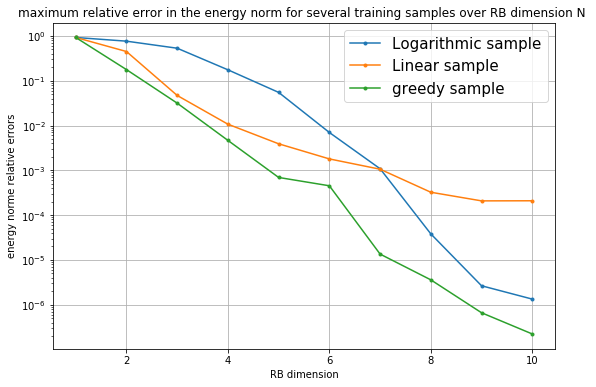

In [760]:
fig, ax = plt.subplots(figsize=(9,6))
ax.set(xlabel='RB dimension', ylabel='energy norme relative errors', \
       title= "maximum relative error in the energy norm for several training samples over RB dimension N ")
ax.plot(range(1,11),log_list,'.-',label=r"Logarithmic sample")
ax.plot(range(1,11),linear_list,'.-',label=r"Linear sample")
ax.plot(range(1,11),greedy_list,'.-',label=r"greedy sample")
ax.set_yscale('log')
ax.grid(True)
ax.legend(loc='best',fontsize=15);

**Comment:**
    
The greedy sample is obviously the quickest and the most precise!

**Observation:**
    
If the the greedy sample is sorted the result is different. In fact the logarithmic sample gives better results than the greedy one as shown below.

In [766]:
%%time
Q6_c_1_sorted = plot_rel_error(50,greedy_sample_sorted,11)
greedy_list_sorted = Q6_c_1_sorted.max_rel_error_enorm_list

CPU times: user 43.1 s, sys: 1.72 s, total: 44.8 s
Wall time: 15.1 s


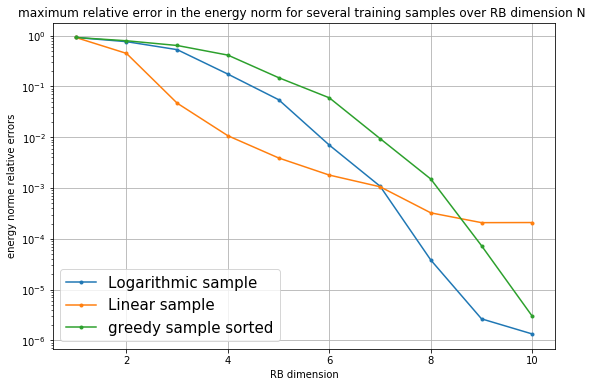

In [767]:
fig, ax = plt.subplots(figsize=(9,6))
ax.set(xlabel='RB dimension', ylabel='energy norme relative errors', \
       title= "maximum relative error in the energy norm for several training samples over RB dimension N ")
ax.plot(range(1,11),log_list,'.-',label=r"Logarithmic sample")
ax.plot(range(1,11),linear_list,'.-',label=r"Linear sample")
ax.plot(range(1,11),greedy_list_sorted,'.-',label=r"greedy sample sorted")
ax.set_yscale('log')
ax.grid(True)
ax.legend(loc='best',fontsize=15);

## Question 7:

### Sub-question (a):

In [789]:
%%time
Q7_a = RB_PB3_greedy(Nmax=1000,Q=6,P=2,triangulation ='medium',train_max = 50,grid ='linlog')
Q7_a.constructing_sample(tol=1e-6)

first value of delta_{max,en} is:  3.484222919205862
The RB dimension to reach a precision of 1e-06  is:  53
CPU times: user 3h 30min 50s, sys: 6min 4s, total: 3h 36min 54s
Wall time: 1h 41min 5s


**comment:**

As shown above the required RB dimension to reach a precision of `1e-6` is `Nmax = 53`. it requires roughly a cpu time of over `1 hour` which is drastically higher than the one required for the case 1. This is expected as the training sample raised from 100 to $25\times 25 = 625$ combination to test for each iteration. In that case, for operational purposes, if such precision is not required one has to decrease it to a minimal accepted value (e.g. 1e-2).


### Sub-question (b):

first value of delta_{max,en} is:  3.484222919205862
The RB dimension to reach a precision of 1e-06  is:  53


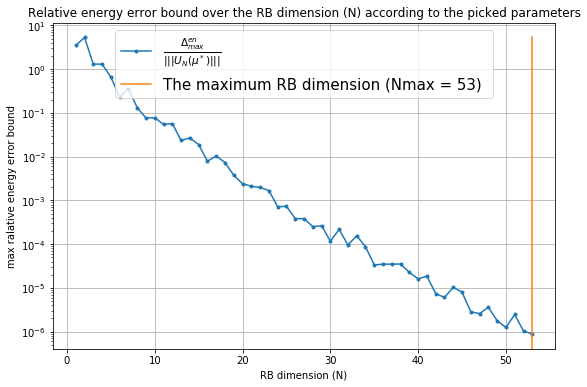

In [638]:
Q7_b = RB_PB3_greedy(Nmax=1000,Q=6,P=2,triangulation ='medium',train_max = 25,grid ='linlog')
Q7_b.constructing_sample(tol=1e-6,plot='overview')

**Let's try for the following cases:**

* tol =`1e-2` (only change)
* train sample size = `10` (only change)
* both

**tol =`1e-2` (only change)**

first value of delta_{max,en} is:  3.484222919205862
The RB dimension to reach a precision of 0.01  is:  16
CPU times: user 8min 44s, sys: 19 s, total: 9min 3s
Wall time: 3min 2s


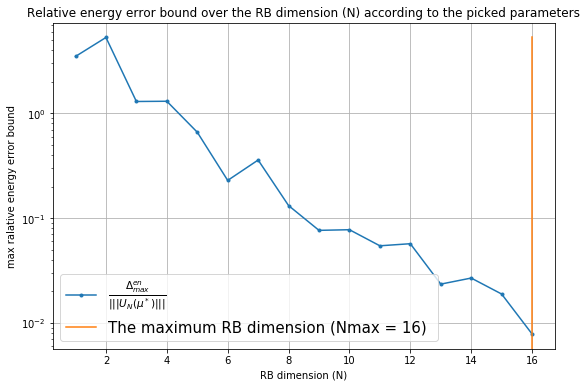

In [645]:
%%time
Q6_b_1 = RB_PB3_greedy(Nmax=1000,Q=6,P=2,triangulation ='medium',train_max = 25,grid ='linlog')
Q6_b_1.constructing_sample(tol=1e-2,plot='overview')

**train sample size = `10` (only change)**

first value of delta_{max,en} is:  3.484222919205862
The RB dimension to reach a precision of 1e-06  is:  50
CPU times: user 8min 19s, sys: 14.9 s, total: 8min 34s
Wall time: 3min 51s


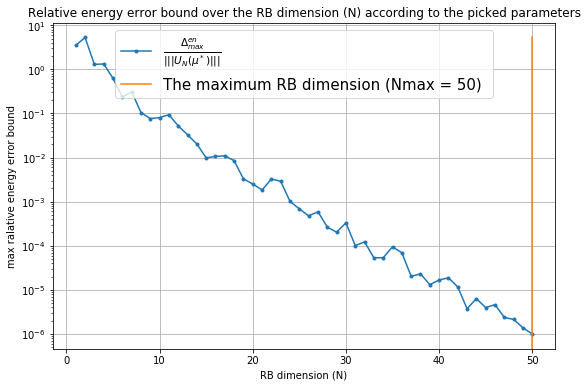

In [646]:
%%time
Q6_b_2 = RB_PB3_greedy(Nmax=1000,Q=6,P=2,triangulation ='medium',train_max = 10,grid ='linlog')
Q6_b_2.constructing_sample(tol=1e-6,plot='overview')

**Both changes**

first value of delta_{max,en} is:  3.484222919205862
The RB dimension to reach a precision of 0.01  is:  15
CPU times: user 1min 25s, sys: 3.12 s, total: 1min 28s
Wall time: 30.1 s


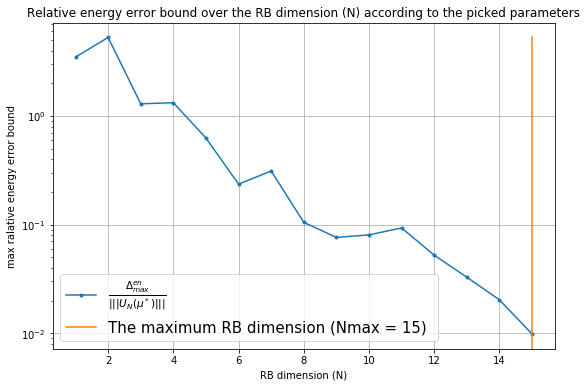

In [647]:
%%time
Q6_b_3 = RB_PB3_greedy(Nmax=1000,Q=6,P=2,triangulation ='medium',train_max = 10,grid ='linlog')
Q6_b_3.constructing_sample(tol=1e-2,plot='overview')

**Observation:**

The case with less training samples is quicker as time consuming as the one with low precision but big samples. The third case is much quicker only seconds instead of over `8 minutes` bor the previous cases. We can also see that the number of RB dimension is related to the precision which can be reach for a trainig grid sample with smaller size and less cpu time `8 minutes` instead of `1 hour`. **What is the cost then for such working condition and how to evaluate it?**


### Sub-question (c):

**Distribution of the greedy sample**

In [809]:
SN = np.array(Q7_a.S1)
#SN

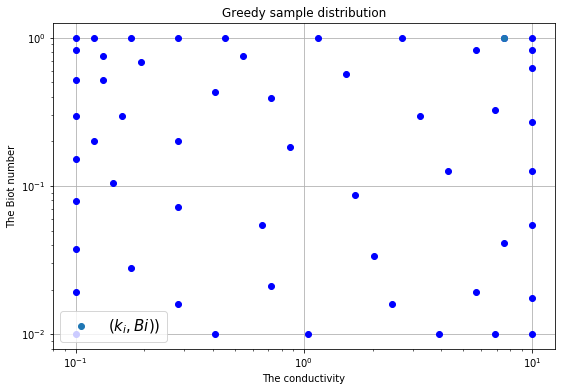

In [794]:
fig, ax = plt.subplots(figsize=(9,6))
for S in SN:
    
    ax.set(xlabel='The conductivity', ylabel='The Biot number', \
           title= "Greedy sample distribution")
    ax.plot(S[0],S[1],'bo')
    
ax.plot(S[0],S[1],'o',label=r"$(k_i,Bi)$)")
ax.set_yscale('log')
ax.set_xscale('log')
ax.grid(True)
ax.legend(loc='best',fontsize=15);

**Interpretation of the distribution:**
    
Larger Bi means better heat transfer which is normally the expected case of an operationnal thermal fin and the same goes for the conductivities. In fact, when the chip temperature is heating up its material should be with high conductivity otherwise that would ruin the circuits. Now if the root material is different than the fin material that would influence $k_i$ value as they are all divided by $k_0$. That explains more density on high Bi numbers and eaither very low or very high values of $k_i$. Type of material of the root material or $k_0$ would definitely help finding a better sampling. From the distribution we can already guess that is not the same material.

### Sub-question (d):

In [806]:
def plot_rel_error(test_max,training_sample,Nmax,P=1):
    Q7_d = RB_PB3_greedy(Nmax=Nmax,Q=6,P=P,triangulation ='medium',train_max = Nmax,grid ='linlog',test_max=test_max)
    Q7_d.load_matrices_samples()
    for i in range(1,Nmax):
        offline = Q7_d.offline_decomposition(i)
        offline.calculate_rel_max_error(i,training_sample,Nmax)
        
    return Q7_d

In [807]:
%%time
Q7_d = plot_rel_error(10,SN,54,2)
max_rel_error = Q7_d.max_rel_error_enorm_list
max_output_error = Q7_d.max_erreur_root_list

CPU times: user 16min 26s, sys: 36.3 s, total: 17min 3s
Wall time: 5min 29s


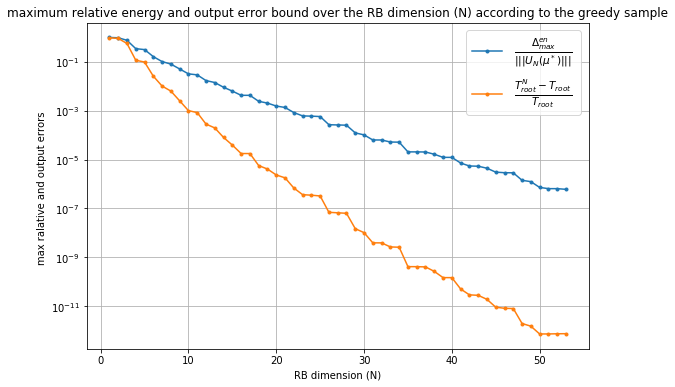

In [810]:
fig, ax = plt.subplots(figsize=(9,6))
ax.set(xlabel='RB dimension (N)', ylabel='max ralative and output errors ', \
       title= "maximum relative energy and output error bound over the RB dimension (N) according to the greedy sample")

ax.plot(range(1,54),max_rel_error,'.-',label=r"$\frac {\Delta^{en}_{max}}{||| U_N(\mu^*) |||}$ ")
ax.plot(range(1,54),max_output_error,'.-',label=r"$\frac {T_{root}^N -T_{root}}{T_{root}}$ ")
ax.set_yscale('log')
ax.grid(True)
ax.legend(loc='best',fontsize=15);

**Commentaire:**
The precision reached with 53 basis of the RB set is less than `1e-11` for the relative output error. It is as expected around the square of the relative energy error for the nergy norm as shown below.

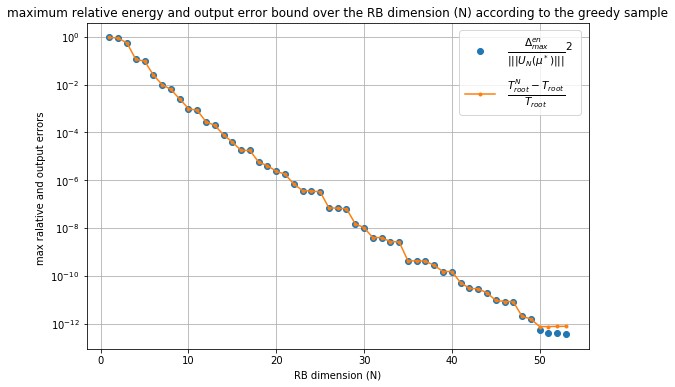

In [813]:
fig, ax = plt.subplots(figsize=(9,6))
ax.set(xlabel='RB dimension (N)', ylabel='max ralative and output errors ', \
       title= "maximum relative energy and output error bound over the RB dimension (N) according to the greedy sample")

ax.plot(range(1,54),np.array(max_rel_error)**2,'o',label=r"$\frac {\Delta^{en}_{max}}{||| U_N(\mu^*) |||}^2$ ")
ax.plot(range(1,54),max_output_error,'.-',label=r"$\frac {T_{root}^N -T_{root}}{T_{root}}$ ")
ax.set_yscale('log')
ax.grid(True)
ax.legend(loc='best',fontsize=15);

**Comment:**
It is not perfectly matching because it is only a maximum estimation based on the $\Xi^{test}$ sample. Also when we reach the machine precision, the accuracy is not garanteed.